# Suite du projet 4: Modèlisation

# <font color="#1d479b">Sommaire</font>

1. [Preprocessing](#partie1)
  * 1.1. [Encodage et standardisation](#partie1_1)
  * 1.2. [Préparation des données d'entrainement et de test](#partie1_2)
  * 1.3  [Séparation des jeux de données](#partie1_3)
2.  [Modélisation multitests](#partie2)
  * 2.1. [Entrainement et modélisation de nos modèles nos optimisés](#partie1_1)
  * 2.2. [Affichage des résultats et évaluation de nos modèles non optimisés](#partie1_2)
3.  [Optimisation et entrainement de nos modèles](#partie3)
  * 3.1. [Entrainement des modèles avec hyperparamétrisation](#partie1_1)
  * 3.2. [Evaluation de nos modèles](#partie1_1)
  * 3.3. [Courbes d'apprentissate](#partie1_1)
4.  [Prédiction sur les données de test et évaluation de performances de nos modèles](#partie4)
  * 4.1. [Features importantes](#partie1_1)
  * 4.2. [Prédictions et évaluation de nos prédictions](#partie4_2)
5.  [Interêt de la varaible ENERGYSTARSCore](#partie5)
  
  

In [9]:
# Librairies communes pour le ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

#mesurer le temps
import timeit

# Séparateur de jeu de données
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Modèles

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Métrics
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.utils import check_array

# Cross validation 
from sklearn.model_selection import cross_val_score,validation_curve
from sklearn.model_selection import cross_validate, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

# Création de pipelines
from sklearn.pipeline import Pipeline

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [10]:
data = pd.read_csv('peclec_data_Nettoye.csv')

In [11]:
data

,Unnamed: 0,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,TotalGHGEmissions,SiteEnergyUse(kBtu),ENERGYSTARScore,log2SiteEnergyUse(kBtu),log2TotalGHGEmissions,BuildingAge
0,0,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,12.0,88434.0,98101.0,249.43,6981428.00,65.0,22.735091,7.968264,88.0
1,1,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,11.0,103566.0,98101.0,263.51,8354235.00,51.0,22.994076,8.047178,19.0
2,2,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,41.0,961990.0,98101.0,2061.48,73130656.00,18.0,26.123973,11.010164,46.0
3,3,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,10.0,61320.0,98101.0,1936.34,28229320.00,1.0,24.750691,10.919861,89.0
4,4,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,18.0,119890.0,98121.0,507.70,14829099.00,67.0,23.821928,8.990671,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1595,NonResidential,Small- and Mid-Sized Office,Office,GREATER DUWAMISH,1.0,2.0,24990.0,98108.0,134.80,4420650.50,9.0,22.075828,7.085340,87.0
1596,1596,NonResidential,Other,Leisure,NORTHEAST,1.0,1.0,72000.0,98155.0,67.65,2925780.00,70.2,21.480390,6.101188,3.0
1597,1597,NonResidential,Education,Education,GREATER DUWAMISH,1.0,3.0,45000.0,98144.0,9.24,1325972.75,77.0,20.338621,3.356144,1.0
1598,1598,NonResidential,Mixed Use Property,Laboratory,LAKE UNION,1.0,6.0,345290.0,98109.0,1000.06,39364116.00,92.0,25.230378,9.967313,1.0


# 1.Preprocessing <a class="anchor" id="partie1"></a>

### 1.1 Séparation X et y des jeux de données

#### Idées: 

- Pour les prédictions, nous allons utiliser dans un premier temps l'ensemble des données dont `ENERGYSTARScore` pour faire nos prédictions, puis on utilisera un autre jeu de données mais sans `ENERGYSTARScore`. L'interêt est de voir son impact sur nos données
- Pour la target, on utilisera y= `SiteEnergyUse(kBtu)`et y= `log2pSiteEnergyUse(kBtu)` afin de voir l'impact d'avoir rendu normale la distribution de la target.

In [12]:
#Choix de la target 'SiteEnergyUse(kBtu)'
y = data.copy()[{'SiteEnergyUse(kBtu)','log2SiteEnergyUse(kBtu)','TotalGHGEmissions','log2TotalGHGEmissions'}]

#Choix de X avec la variable ENERGYSTARScore
X = data.copy().drop([ 'SiteEnergyUse(kBtu)','TotalGHGEmissions','Unnamed: 0','log2SiteEnergyUse(kBtu)','log2TotalGHGEmissions'], axis=1) 

In [13]:
X

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,ENERGYSTARScore,BuildingAge
0,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,12.0,88434.0,98101.0,65.0,88.0
1,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,11.0,103566.0,98101.0,51.0,19.0
2,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,41.0,961990.0,98101.0,18.0,46.0
3,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,10.0,61320.0,98101.0,1.0,89.0
4,NonResidential,Hotel/Senior Care/Housing,Hotel/Senior Care/Housing,DOWNTOWN,1.0,18.0,119890.0,98121.0,67.0,35.0
...,...,...,...,...,...,...,...,...,...,...
1595,NonResidential,Small- and Mid-Sized Office,Office,GREATER DUWAMISH,1.0,2.0,24990.0,98108.0,9.0,87.0
1596,NonResidential,Other,Leisure,NORTHEAST,1.0,1.0,72000.0,98155.0,70.2,3.0
1597,NonResidential,Education,Education,GREATER DUWAMISH,1.0,3.0,45000.0,98144.0,77.0,1.0
1598,NonResidential,Mixed Use Property,Laboratory,LAKE UNION,1.0,6.0,345290.0,98109.0,92.0,1.0


In [107]:
y

,log2TotalGHGEmissions,TotalGHGEmissions,SiteEnergyUse(kBtu),log2SiteEnergyUse(kBtu)
0,7.968264,249.43,6981428.00,22.735091
1,8.047178,263.51,8354235.00,22.994076
2,11.010164,2061.48,73130656.00,26.123973
3,10.919861,1936.34,28229320.00,24.750691
4,8.990671,507.70,14829099.00,23.821928
...,...,...,...,...
1594,7.085340,134.80,4420650.50,22.075828
1595,6.101188,67.65,2925780.00,21.480390
1596,3.356144,9.24,1325972.75,20.338621
1597,9.967313,1000.06,39364116.00,25.230378


### 1.2 Séparation jeu de données X_train/y_train, X_test/y_test

Afin de **tester notre meilleur modèle** sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test *(20% des données)* Nous réalisons ce split avec comme varaible cible ``TotalGHGEmissions`` et ``SiteEnergyUse(kBtu)``

In [29]:
# TARGET: "TotalGHGEmissions"
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y['TotalGHGEmissions'],  test_size = 0.2)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1280, 10)
X_test shape: (320, 10)
y_train shape: (1280,)
y_test shape: (320,)


In [56]:
# TARGET: "SiteEnergyUse(kBtu)"
from sklearn.model_selection import train_test_split
X_train_s, X_test_s, y_train_s, y_test_s =train_test_split(X,y['SiteEnergyUse(kBtu)'],  test_size = 0.2)

print('X_train shape:', X_train_s.shape)
print('X_test shape:', X_test_s.shape)
print('y_train shape:', y_train_s.shape)
print('y_test shape:', y_test_s.shape)

X_train shape: (1280, 10)
X_test shape: (320, 10)
y_train shape: (1280,)
y_test shape: (320,)


### 1.3  One Hot Encoding & Standardisation 

- On utlise le OneHotEncoder pour labeliser nos données catégorielles

- Puis les données numériques doivent être standardisées pour entrer dans nos modèles de prédiction. Nous réaliserons un **centrage-réduction** via la méthode `StandardScaler` de Scikit-Learn.

- Ces opérations seront réalisées sur les des targets ``TotalGHGEmissions`` et `SiteEnergyUse(kBtu)`

In [16]:
#Observation des données catégorielles
X.select_dtypes(['category','object']).nunique()

BuildingType               5
PrimaryPropertyType       18
LargestPropertyUseType    26
Neighborhood              13
dtype: int64

In [17]:
# Colonnes catégorielles
categorical_columns = X.select_dtypes(['object']).columns

#Colonnes numériques
numerical_columns = X.select_dtypes(['int32','float64']).columns

In [18]:
categorical_columns

Index(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
       'Neighborhood'],
      dtype='object')

### a/ One Hot Encoding

#### - TARGET : ``TotalGHGEmissions``

In [30]:
ohe0 = OneHotEncoder(categories='auto')

In [31]:
feature_arry1 = ohe0.fit(X_train[categorical_columns])
feature_arry1 = ohe0.transform(X_train[categorical_columns]).toarray()
feature_arry2 = ohe0.transform(X_test[categorical_columns]).toarray()


In [33]:
feature_labels0 = ohe0.categories_
feature_labels0

[array(['Campus', 'NonResidential', 'Nonresidential COS',
        'Nonresidential WA', 'SPS-District K-12'], dtype=object),
 array(['Distribution Center\n', 'Education', 'Health', 'Hospital',
        'Hotel/Senior Care/Housing', 'Large Office', 'Leisure',
        'Low-Rise Multifamily', 'Mixed Use Property',
        'Non-Refrigerated Warehouse', 'Other', 'Refrigerated Warehouse',
        'Residence Hall', 'Restaurant\n', 'Retail',
        'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
        'Warehouse'], dtype=object),
 array(['Convention Center', 'Courthouse', 'Data Center',
        'Distribution Center', 'Education', 'Fire Station', 'Health',
        'Hospital (General Medical & Surgical)',
        'Hotel/Senior Care/Housing', 'Laboratory', 'Leisure',
        'Lifestyle Center', 'Manufacturing/Industrial Plant',
        'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Utility',
        'Other/Specialty Hospital',
        'Outpatient Rehabilitation/Physical Thera

In [34]:
#Toutes les valeurs des variables à labaliser
data_one_var = pd.DataFrame(feature_arry1, columns = ['Campus', 'NonResidential', 'Nonresidential COS',
        'Nonresidential WA', 'SPS-District K-12','Distribution Center\n', 'Education', 'Health', 'Hospital',
        'Hotel/Senior Care/Housing', 'Large Office', 'Leisure',
        'Low-Rise Multifamily', 'Mixed Use Property',
        'Non-Refrigerated Warehouse', 'Other', 'Refrigerated Warehouse',
        'Residence Hall', 'Restaurant\n', 'Retail',
        'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
        'Warehouse','Convention Center', 'Courthouse', 'Data Center',
        'Distribution Center', 'Education', 'Fire Station', 'Health',
        'Hospital (General Medical & Surgical)',
        'Hotel/Senior Care/Housing', 'Laboratory', 'Leisure',
        'Lifestyle Center', 'Manufacturing/Industrial Plant',
        'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Utility',
        'Other/Specialty Hospital',
        'Outpatient Rehabilitation/Physical Therapy', 'Parking',
        'Personal Services (Health/Beauty, Dry Cleaning, etc)',
        'Police Station', 'Refrigerated Warehouse', 'Retail',
        'Self-Storage Facility', 'Urgent Care/Clinic/Other Outpatient','BALLARD', 'CENTRAL', 'DELRIDGE', 'DOWNTOWN', 'EAST',
        'GREATER DUWAMISH', 'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'NORTH',
        'NORTHEAST', 'NORTHWEST', 'SOUTHEAST', 'SOUTHWEST'])

In [35]:
#Toutes les valeurs des variables à labaliser
data_one_var_test = pd.DataFrame(feature_arry2, columns = ['Campus', 'NonResidential', 'Nonresidential COS',
        'Nonresidential WA', 'SPS-District K-12','Distribution Center\n', 'Education', 'Health', 'Hospital',
        'Hotel/Senior Care/Housing', 'Large Office', 'Leisure',
        'Low-Rise Multifamily', 'Mixed Use Property',
        'Non-Refrigerated Warehouse', 'Other', 'Refrigerated Warehouse',
        'Residence Hall', 'Restaurant\n', 'Retail',
        'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
        'Warehouse','Convention Center', 'Courthouse', 'Data Center',
        'Distribution Center', 'Education', 'Fire Station', 'Health',
        'Hospital (General Medical & Surgical)',
        'Hotel/Senior Care/Housing', 'Laboratory', 'Leisure',
        'Lifestyle Center', 'Manufacturing/Industrial Plant',
        'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Utility',
        'Other/Specialty Hospital',
        'Outpatient Rehabilitation/Physical Therapy', 'Parking',
        'Personal Services (Health/Beauty, Dry Cleaning, etc)',
        'Police Station', 'Refrigerated Warehouse', 'Retail',
        'Self-Storage Facility', 'Urgent Care/Clinic/Other Outpatient','BALLARD', 'CENTRAL', 'DELRIDGE', 'DOWNTOWN', 'EAST',
        'GREATER DUWAMISH', 'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'NORTH',
        'NORTHEAST', 'NORTHWEST', 'SOUTHEAST', 'SOUTHWEST'])

In [36]:
data_one_var_test

,Campus,NonResidential,Nonresidential COS,Nonresidential WA,SPS-District K-12,Distribution Center\n,Education,Health,Hospital,Hotel/Senior Care/Housing,...,DOWNTOWN,EAST,GREATER DUWAMISH,LAKE UNION,MAGNOLIA / QUEEN ANNE,NORTH,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
316,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
317,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
df_one_var = pd.concat([data_one_var.reset_index(drop=True),X_train.drop(categorical_columns,axis=1).reset_index(drop=True)],axis=1)

In [38]:
X_train = df_one_var.copy()

In [39]:
liste_variables = list(X_train.columns)
liste_variables

['Campus',
 'NonResidential',
 'Nonresidential COS',
 'Nonresidential WA',
 'SPS-District K-12',
 'Distribution Center\n',
 'Education',
 'Health',
 'Hospital',
 'Hotel/Senior Care/Housing',
 'Large Office',
 'Leisure',
 'Low-Rise Multifamily',
 'Mixed Use Property',
 'Non-Refrigerated Warehouse',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall',
 'Restaurant\n',
 'Retail',
 'Self-Storage Facility\n',
 'Small- and Mid-Sized Office',
 'Warehouse',
 'Convention Center',
 'Courthouse',
 'Data Center',
 'Distribution Center',
 'Education',
 'Fire Station',
 'Health',
 'Hospital (General Medical & Surgical)',
 'Hotel/Senior Care/Housing',
 'Laboratory',
 'Leisure',
 'Lifestyle Center',
 'Manufacturing/Industrial Plant',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Utility',
 'Other/Specialty Hospital',
 'Outpatient Rehabilitation/Physical Therapy',
 'Parking',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Police Station',
 'Refrigerated Warehouse',
 'Reta

In [40]:
df_one_var_test = pd.concat([data_one_var_test.reset_index(drop=True),X_test.drop(categorical_columns,axis=1).reset_index(drop=True)],axis=1)

In [41]:
df_one_var_test.columns

Index(['Campus', 'NonResidential', 'Nonresidential COS', 'Nonresidential WA',
       'SPS-District K-12', 'Distribution Center\n', 'Education', 'Health',
       'Hospital', 'Hotel/Senior Care/Housing', 'Large Office', 'Leisure',
       'Low-Rise Multifamily', 'Mixed Use Property',
       'Non-Refrigerated Warehouse', 'Other', 'Refrigerated Warehouse',
       'Residence Hall', 'Restaurant\n', 'Retail', 'Self-Storage Facility\n',
       'Small- and Mid-Sized Office', 'Warehouse', 'Convention Center',
       'Courthouse', 'Data Center', 'Distribution Center', 'Education',
       'Fire Station', 'Health', 'Hospital (General Medical & Surgical)',
       'Hotel/Senior Care/Housing', 'Laboratory', 'Leisure',
       'Lifestyle Center', 'Manufacturing/Industrial Plant',
       'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Utility',
       'Other/Specialty Hospital',
       'Outpatient Rehabilitation/Physical Therapy', 'Parking',
       'Personal Services (Health/Beauty, Dry Cleaning

In [42]:
X_test = df_one_var_test.copy()

In [43]:
X_test

,Campus,NonResidential,Nonresidential COS,Nonresidential WA,SPS-District K-12,Distribution Center\n,Education,Health,Hospital,Hotel/Senior Care/Housing,...,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,ENERGYSTARScore,BuildingAge
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,21600.0,98134.0,55.0,88.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,10.0,130513.0,98101.0,49.0,105.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,7.0,128766.0,98101.0,57.8,101.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,114000.0,98133.0,96.0,48.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,36.0,794592.0,98101.0,97.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,43183.0,98109.0,1.0,62.0
316,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,41526.0,98106.0,72.0,45.0
317,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,2.0,20039.0,98105.0,99.0,61.0
318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,2.0,75868.0,98122.0,80.8,59.0


#### - TARGET : ``SiteEnergyUse(kBtu)``

In [57]:
feature_arry_site = ohe0.fit(X_train_s[categorical_columns])
feature_arry_site = ohe0.transform(X_train_s[categorical_columns]).toarray()
feature_arry_site_test = ohe0.transform(X_test_s[categorical_columns]).toarray()

In [58]:
#Toutes les valeurs des variables à labaliser
data_one_var_site = pd.DataFrame(feature_arry_site, columns = ['Campus', 'NonResidential', 'Nonresidential COS',
        'Nonresidential WA', 'SPS-District K-12','Distribution Center\n', 'Education', 'Health', 'Hospital',
        'Hotel/Senior Care/Housing', 'Large Office', 'Leisure',
        'Low-Rise Multifamily', 'Mixed Use Property',
        'Non-Refrigerated Warehouse', 'Other', 'Refrigerated Warehouse',
        'Residence Hall', 'Restaurant\n', 'Retail',
        'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
        'Warehouse','Convention Center', 'Courthouse', 'Data Center',
        'Distribution Center', 'Education', 'Fire Station', 'Health',
        'Hospital (General Medical & Surgical)',
        'Hotel/Senior Care/Housing', 'Laboratory', 'Leisure',
        'Lifestyle Center', 'Manufacturing/Industrial Plant',
        'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Utility',
        'Other/Specialty Hospital',
        'Outpatient Rehabilitation/Physical Therapy', 'Parking',
        'Personal Services (Health/Beauty, Dry Cleaning, etc)',
        'Police Station', 'Refrigerated Warehouse', 'Retail',
        'Self-Storage Facility', 'Urgent Care/Clinic/Other Outpatient','BALLARD', 'CENTRAL', 'DELRIDGE', 'DOWNTOWN', 'EAST',
        'GREATER DUWAMISH', 'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'NORTH',
        'NORTHEAST', 'NORTHWEST', 'SOUTHEAST', 'SOUTHWEST'])


In [59]:
#Toutes les valeurs des variables à labaliser
data_one_var_site_test = pd.DataFrame(feature_arry_site_test, columns =['Campus', 'NonResidential', 'Nonresidential COS',
        'Nonresidential WA', 'SPS-District K-12','Distribution Center\n', 'Education', 'Health', 'Hospital',
        'Hotel/Senior Care/Housing', 'Large Office', 'Leisure',
        'Low-Rise Multifamily', 'Mixed Use Property',
        'Non-Refrigerated Warehouse', 'Other', 'Refrigerated Warehouse',
        'Residence Hall', 'Restaurant\n', 'Retail',
        'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
        'Warehouse','Convention Center', 'Courthouse', 'Data Center',
        'Distribution Center', 'Education', 'Fire Station', 'Health',
        'Hospital (General Medical & Surgical)',
        'Hotel/Senior Care/Housing', 'Laboratory', 'Leisure',
        'Lifestyle Center', 'Manufacturing/Industrial Plant',
        'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Utility',
        'Other/Specialty Hospital',
        'Outpatient Rehabilitation/Physical Therapy', 'Parking',
        'Personal Services (Health/Beauty, Dry Cleaning, etc)',
        'Police Station', 'Refrigerated Warehouse', 'Retail',
        'Self-Storage Facility', 'Urgent Care/Clinic/Other Outpatient','BALLARD', 'CENTRAL', 'DELRIDGE', 'DOWNTOWN', 'EAST',
        'GREATER DUWAMISH', 'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'NORTH',
        'NORTHEAST', 'NORTHWEST', 'SOUTHEAST', 'SOUTHWEST'])

In [60]:
df_one_var_site = pd.concat([data_one_var_site.reset_index(drop=True),X_train_s.drop(categorical_columns,axis=1).reset_index(drop=True)],axis=1)

In [61]:
X_train_s = df_one_var_site.copy()

In [62]:
df_one_var_site_test = pd.concat([data_one_var_site_test.reset_index(drop=True),X_test_s.drop(categorical_columns,axis=1).reset_index(drop=True)],axis=1)

In [63]:
X_test_s = df_one_var_site_test.copy()

In [64]:
X_test_s

,Campus,NonResidential,Nonresidential COS,Nonresidential WA,SPS-District K-12,Distribution Center\n,Education,Health,Hospital,Hotel/Senior Care/Housing,...,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,ENERGYSTARScore,BuildingAge
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,44098.0,98101.0,29.0,90.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,27000.0,98134.0,91.4,99.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,5.0,137738.0,98102.0,61.0,30.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,5.0,251827.0,98102.0,83.6,13.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,3.0,40304.0,98116.0,7.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,19.0,319911.0,98104.0,53.0,42.0
316,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.0,23422.0,98122.0,64.0,95.0
317,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,41521.0,98116.0,49.4,67.0
318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,11.0,526423.0,98109.0,98.0,3.0


### b/ Standardisation 

In [65]:
# Standardisation sur la TARGET TotalGHGEmissions
std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)


In [66]:
X_train

array([[-0.13224249, -2.7762354 ,  4.47030274, ..., -0.47099603,
         1.37448463, -1.5856566 ],
       [-0.13224249, -2.7762354 ,  4.47030274, ..., -0.47099603,
         0.02599498, -0.03839707],
       [-0.13224249,  0.3602    , -0.2236985 , ..., -0.7739178 ,
        -1.25750721,  0.02227978],
       ...,
       [ 7.56186605, -2.7762354 , -0.2236985 , ..., -0.95567086,
        -0.57513896,  1.84258511],
       [-0.13224249,  0.3602    , -0.2236985 , ...,  0.13484752,
        -0.77822475,  0.14363347],
       [-0.13224249,  0.3602    , -0.2236985 , ...,  0.25601623,
         1.04954736, -0.06873549]])

In [67]:
# Standardisation sur la TARGET SiteEnergyUse(kBtu)
std_s = StandardScaler().fit(X_train_s)
X_train_s = std_s.transform(X_train_s)
X_test_s = std_s.transform(X_test_s)

In [68]:
X_train_s

array([[ 8.1466816 , -2.80871659, -0.199512  , ..., -0.95239814,
        -1.10942992,  1.63669744],
       [-0.12274937,  0.3560345 , -0.199512  , ...,  0.13805821,
         0.1254346 ,  0.93733937],
       [-0.12274937,  0.3560345 , -0.199512  , ..., -0.46775087,
         1.09739248,  0.02513318],
       ...,
       [-0.12274937,  0.3560345 , -0.199512  , ...,  1.65258091,
         0.49987739, -1.40398985],
       [-0.12274937,  0.3560345 , -0.199512  , ...,  4.98453085,
         0.89822078, -1.40398985],
       [-0.12274937,  0.3560345 , -0.199512  , ...,  1.65258091,
         0.34054003, -0.85666613]])

# 2. Entrainement de plusieurs modèles et prédiction sans optimisation <a class="anchor" id="partie2"></a>

### Idée: 
- L'idée dans cette étape de notre étude estde voir avec une seule target, quels sont les modèles **potentiellement** prometteurs qu'on peut optimiser par la suite. Pour cela, nous allons: 
   - Entrainenement et prédiction en utilisant plusieurs modèles non optimisés
   - On utilisera, le métriques  RMSE pour la validation croisée sur la target ``TotalGHGEmissions``

### 2.1 Entrainement et modélisation de nos modèles nos optimisés

In [206]:
# Dictionnaire de plusieurs regresseurs pour avoir une idée de du comprtement de chacun d'eux
random_state_const = 0
regressors = {          
    LinearRegression(),
    Ridge(random_state = random_state_const),
    Lasso(random_state = random_state_const),
    DummyRegressor(),
    ElasticNet(random_state = random_state_const),
    SVR(C=1.0, kernel="rbf", gamma=0.01),
    KNeighborsRegressor(3),
    DecisionTreeRegressor(random_state = random_state_const),
    RandomForestRegressor(random_state = random_state_const),
    AdaBoostRegressor(random_state = random_state_const),
    ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
    GradientBoostingRegressor(random_state = random_state_const),
                  }

In [207]:
# Les regressors sont testés 1 à 1 par cross-validation
def modelisation(X_train, X_test, y_train, y_test, regressors):
# Fonction permettant d'entrainer tous les modèles puis de faire des prédictions pour chacun des modèles (regresseurs)
    
# Instation du tableau des résultats de tous les modèles    
    df_temp = pd.DataFrame()
    for regressor in regressors:
        
        #Entrainement du modèle
        pipe = Pipeline(steps=[('regressor', regressor)])
        #pipe.fit(X_train, y_train.values.ravel())
        pipe.fit(X_train, y_train)
    
        #Prédictions
        y_pred = regressor.predict(X_test)
        
        #Construction du tableau de résultats
        #Nous créons un tableau par modèle
        #On récupère le nom du modèle
        str_reg = str(regressor)
        str_reg = str_reg[0:str_reg.find("(")]
        
        #Création du tableau de résultats
        df1 = pd.DataFrame(y_pred)
        df2 = y_test.reset_index()
        #On concatène les prédictions et les vraies valeurs en les passant à l'exponentielle car les valeurs sont en log
        
        # Fonction pour la transformation inverse sur nos variables à prédire       
        #df3 = pd.concat([np.exp(df2) , np.exp(df1) ], axis=1, sort=False)
        df3 = pd.concat([df2, df1], axis=1, sort=False)
        df3.columns = ["index", "y_test", "y_pred"]
        df3.drop("index", axis=1, inplace=True)
        
        #On rajoute le nouveau modèle au tableau des résultats
        df_temp = pd.concat([df_temp, calcul_scores(df3, str_reg)])
        
    return df_temp

In [208]:
#Fonction dans laquelle sont calculés les scores de preidction sur les jeux de tests
def calcul_scores(df1, str_reg):
    
    #On remplit le nom du modèle dans le tableau
    df1["Modeles"] = str_reg

    #On calcule la RMSE
    df1["RMSE"] = round(np.sqrt(mean_squared_error(df1["y_test"], df1["y_pred"])),3)

    #On calcule les y_test-y_pred
    df1["y_test-y_pred"] = df1["y_test"] - df1["y_pred"]

    #Ensuite la valeur absolue
    df1["abs(y_test-y_pred)"] = abs(df1["y_test"] - df1["y_pred"])

    #Pour finir le pourcentage d'erreur
    df1["%error"] = (abs(df1["y_test"] - df1["y_pred"]) / df1["y_test"]) * 100
    
    return df1

In [209]:
#Cette fonction permet de calculer les valeurs moyennes de chaque passe
def synthese_resultats(df_results):
    
    df_synthese = pd.DataFrame(columns=["Modeles", "y_test", "y_pred", "RMSE", "y_test-y_pred", "abs(y_test-y_pred)", "%error"])
    lst_modeles = df_results["Modeles"].unique()

    for modele in lst_modeles:
        df_select_modele = df_results[df_results["Modeles"] == modele]
        df_temp = df_select_modele.groupby(df_select_modele.index).mean()
        df_temp.insert(0, "Modeles", modele)
        df_synthese = pd.concat([df_synthese,df_temp], sort=False)        
    return df_synthese

#### Lancement de la modélisation sur la TARGET =  ``TotalGHGEmissions``

In [210]:
#TARGET = "TotalGHGEmissions"

#On prépare le taleau de synthèse
df_results = pd.DataFrame(columns=["Modeles", "y_test", "y_pred", "RMSE", "y_test-y_pred", "abs(y_test-y_pred)", "%error"])

#Modélisation en 10 étapes pour vérification en validation croisée
i=1
nb_passes = 10
while i <= nb_passes:
    
    print("Passe n°", i)
    print(X_train.shape[0], "observations dans le dataset")
    #print(X_train_s.shape[0], "observations dans le dataset")
    
    #Entrainement des modèles
    df_temp = modelisation(X_train, X_test, y_train, y_test, regressors)  
    #df_temp = modelisation(X_train_s, X_test_s, y_train_s, y_test_s, regressors)  
    df_results = pd.concat([df_results, df_temp], sort=False)
                                    
    i+=1

print("Mise en forme des résultats")
df_synthese = synthese_resultats(df_results)


Passe n° 1
1279 observations dans le dataset
Passe n° 2
1279 observations dans le dataset
Passe n° 3
1279 observations dans le dataset
Passe n° 4
1279 observations dans le dataset
Passe n° 5
1279 observations dans le dataset
Passe n° 6
1279 observations dans le dataset
Passe n° 7
1279 observations dans le dataset
Passe n° 8
1279 observations dans le dataset
Passe n° 9
1279 observations dans le dataset
Passe n° 10
1279 observations dans le dataset
Mise en forme des résultats


In [211]:
#Création d'un tableau avec les moyennes des valeurs collectées à chaque passe
lst_modeles = df_results["Modeles"].unique()
df_mean = pd.DataFrame()
for modele in lst_modeles:   
    df_temp = df_results[df_results["Modeles"] == modele]
    df_temp = df_temp.groupby(df_temp.index, as_index=False).mean()
    df_temp.insert(0,"Modeles", modele)
    df_mean = pd.concat([df_mean, df_temp], sort=False)

In [212]:
#Création d'un tableau avec les résultats moyens de chaque modèle
lst_modeles = df_mean["Modeles"].unique()

rmse = []
#mean_percent_err = []
#median_percent_err = []
r2 = []
df_analyse = pd.DataFrame()
for modele in lst_modeles:  
    df_temp = df_mean[df_mean["Modeles"] == modele]   
    rmse.append(round(df_temp["RMSE"].mean(),3))
   # mean_percent_err.append(round(df_temp["%error"].mean(),3))
   # median_percent_err.append(round(df_temp["%error"].median(),3))
    
    r2.append(round(r2_score(df_temp["y_test"], df_temp["y_pred"]),3))
    
df_analyse["Modeles"] = lst_modeles  
df_analyse["RMSE"] = rmse
#df_analyse["mean_percent_err"] = mean_percent_err
#df_analyse["median_percent_err"] = median_percent_err
#df_analyse["R2"] = r2

### 2.2 Affichage des résultats et évaluation de nos modèles non optimisés

In [213]:
df_analyse=df_analyse.sort_values(by = 'RMSE') # log, avec conversion des données en exp 
df_analyse


,Modeles,RMSE
10,GradientBoostingRegressor,222.156
6,KNeighborsRegressor,249.962
2,DecisionTreeRegressor,269.740
9,ElasticNet,271.477
0,RandomForestRegressor,281.661
8,DummyRegressor,297.128
7,SVR,305.655
5,Lasso,333.414
11,Ridge,335.812
1,LinearRegression,340.683


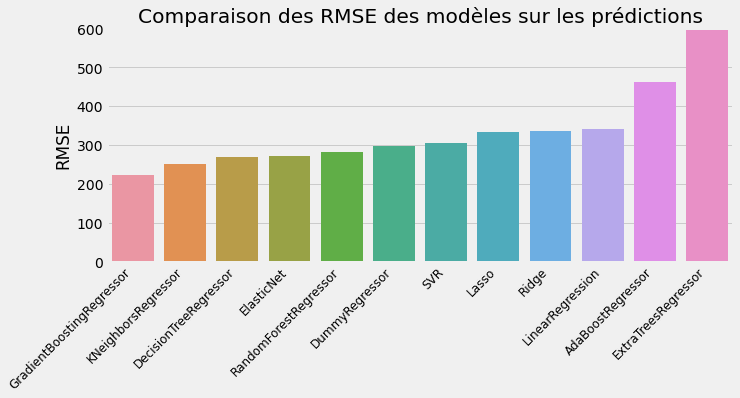

In [214]:
# Comparaison des RMSE des modèles non optimisés
labels = df_analyse["Modeles"].unique()
plt.figure(figsize=(10,4))
plt.title('Comparaison des RMSE des modèles sur les prédictions')
chart = sns.barplot(x = labels,y = df_analyse["RMSE"],order=df_analyse.sort_values('RMSE').Modeles)
chart.set_xticklabels(labels = labels, 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0,600])
plt.show()

**Prémière conclusions**: Au vu de ces résultats, on peut voir que les modèles assemblistes non hyperparametrés ne permettent pas d'avoir de meilleurs résultats pa rarpport aux modèles linéaires.Cependnat, ce graphique peut nous servir de support afin de 

#### Pour l'entrainement et l'optimisation de nos modèles, nous choisirons donc les modèles suivants: 
- Base line: Dummy
- Regressions linéaires: Lasso, Ridge, Elactic Net, SVM
- Assemblistes: RandomFOrest et gradient boost

# 3.Optimisation et entrainements de nos modèles <a class="anchor" id="partie3"></a>

## 3.1 Entrainement des modèles avec optimisation des hyperparamètres

- Pour chaque modèle, on enregistrera, les meilleurs paramètres, la rmse, la mae et la R2 comme métrique.

### a/ Baseline : Regression Dummy

#### Target: ``TotalGHGEmissions``

- Entrainement

In [69]:
parameters = {'strategy' : ['mean','median']}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}

kf = KFold(n_splits=5)
#dum = dummy.DummyRegressor(strategy='mean')

dummy_grid = GridSearchCV(estimator = DummyRegressor(), 
                      param_grid = parameters,
                      scoring=score,
                      #scoring=('neg_mean_squared_error','neg_mean_absolute_error','r2'),
                      return_train_score = True,
                      refit='r2',
                      cv=kf,
                      verbose=1 )
# Entraînement
dummy_grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             return_train_score=True,
             scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error),
                      'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False),
                      'r2': make_scorer(r2_score)},
             verbose=1)

- Enregistrement des résultats

In [129]:
# Définition d'un dataFrame dans lequel, je mets les modèles et les résultats des validations croisées
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation = pd.DataFrame({})

resultValidation = resultValidation.append(pd.DataFrame({
    'Modèle' : ['Dummy'],
    'Best Param' : [dummy_grid.best_params_],
    'RMSE' : [min(dummy_grid.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(dummy_grid.cv_results_['mean_test_r2'])],
    'MAE' :  [ min(dummy_grid.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [130]:
resultValidation

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},725.246664,-0.006916,167.702211


- Affichage des cournes d'apprentissage et de validation

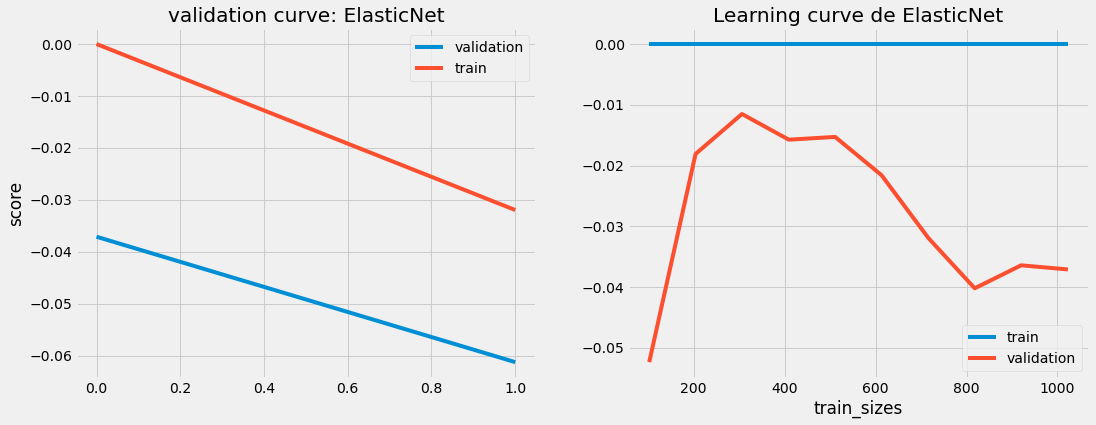

In [215]:
# Affichage des courbes d'apprentissage et de validation 
fig = plt.figure(1, figsize=(25, 6))
plt.subplot(131)
train_scores, valid_scores = validation_curve( DummyRegressor(),X_train,  y_train, param_name="strategy", 
                                              param_range=['mean','median'],cv=5)

plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('')
plt.title("validation curve: ElasticNet")
plt.legend()

plt.subplot(132)
model = dummy_grid.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve')
plt.legend()
plt.title('Learning curve de ElasticNet')
plt.legend()

#### Target: ``SiteEnergyUse(kBtu)``

- Entrainement du modèle

In [72]:
parameters = {'strategy' : ['mean','median']}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}

kf = KFold(n_splits=5)
#dum = dummy.DummyRegressor(strategy='mean')

dummy_grid_s = GridSearchCV(estimator = DummyRegressor(), 
                      param_grid = parameters,
                      scoring=score,
                      #scoring=('neg_mean_squared_error','neg_mean_absolute_error','r2'),
                      return_train_score = True,
                      refit='r2',
                      cv=kf,
                      verbose=1 )
# Entraînement
dummy_grid_s.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             return_train_score=True,
             scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error),
                      'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False),
                      'r2': make_scorer(r2_score)},
             verbose=1)

- Enregistrement des résultats

In [131]:
# Définition d'un dataFrame dans lequel, je mets les modèles et les résultats des validations croisées
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation_s = pd.DataFrame({})
resultValidation_s = resultValidation_s.append(pd.DataFrame({
    'Modèle' : ['Dummy '],
    'Best Param' : [dummy_grid_s.best_params_],
    'RMSE' : [min(dummy_grid_s.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(dummy_grid_s.cv_results_['mean_test_r2'])],
    'MAE' :  [min(dummy_grid_s.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [132]:
resultValidation_s

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},2.837045e+07,-0.029129,7.463001e+06


- Affichage des courbes d'apprentissage et de validation

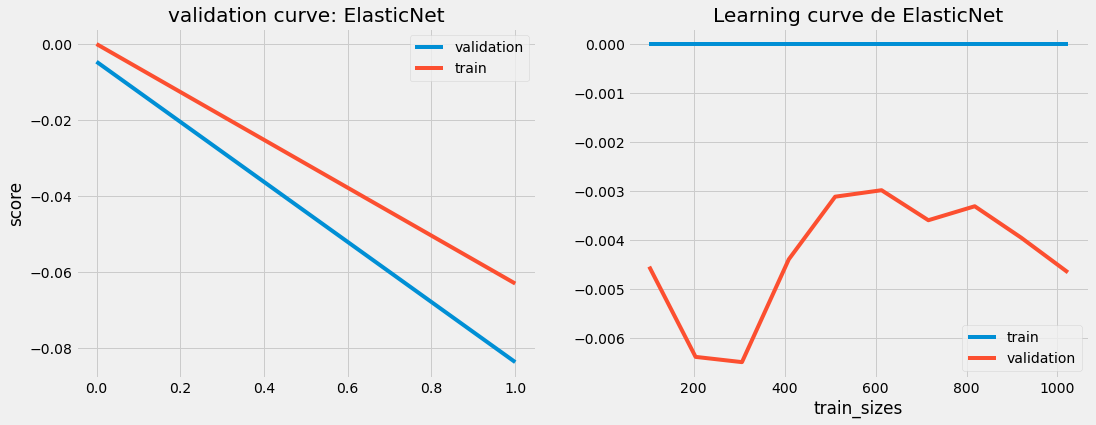

In [216]:
# Affichage des courbes d'apprentissage et de validation 
fig = plt.figure(1, figsize=(25, 6))
plt.subplot(131)
train_scores, valid_scores = validation_curve( DummyRegressor(),X_train_s,  y_train_s, param_name="strategy", 
                                              param_range=['mean','median'],cv=5)

plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('')
plt.title("validation curve: ElasticNet")
plt.legend()

plt.subplot(132)
model = dummy_grid_s.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model, X_train_s, y_train_s, train_sizes=np.linspace(0.1, 1, 10), cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve')
plt.legend()
plt.title('Learning curve de ElasticNet')
plt.legend()

### b/Elactic Net

#### Target: ``TotalGHGEmissions``

In [75]:
#Le modèle Elastic Net comprend les modèles linéaires / ridge et lasso via les valeurs des coefficients dans le grid search CV
import warnings
warnings.filterwarnings('ignore')

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}

kf = KFold(n_splits=5)
parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge


elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      scoring=score,
                      return_train_score = True,
                      refit='r2',
                      cv=kf,
                      verbose=1
                     )

elastic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             refit='r2', return_train_score=True,
             scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error),
                      'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False),
                      'r2': make_scorer(r2_score)},
             verbose=1)

In [133]:
# Définition d'un dataFrame dans lequel, je mets les modèles et les résultats des validations croisées
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation = resultValidation.append(pd.DataFrame({
    'Modèle' : ['Elastic Net'],
    'Best Param' : [elastic_grid.best_params_],
    'RMSE' : [min(elastic_grid.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(elastic_grid.cv_results_['mean_test_r2'])],
    'MAE' :  [min(elastic_grid.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [134]:
resultValidation

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},725.246664,-0.006916,167.702211
1,Elastic Net,"{'alpha': 1, 'l1_ratio': 0.9, 'tol': 0.0001}",536.937051,0.399772,163.465150


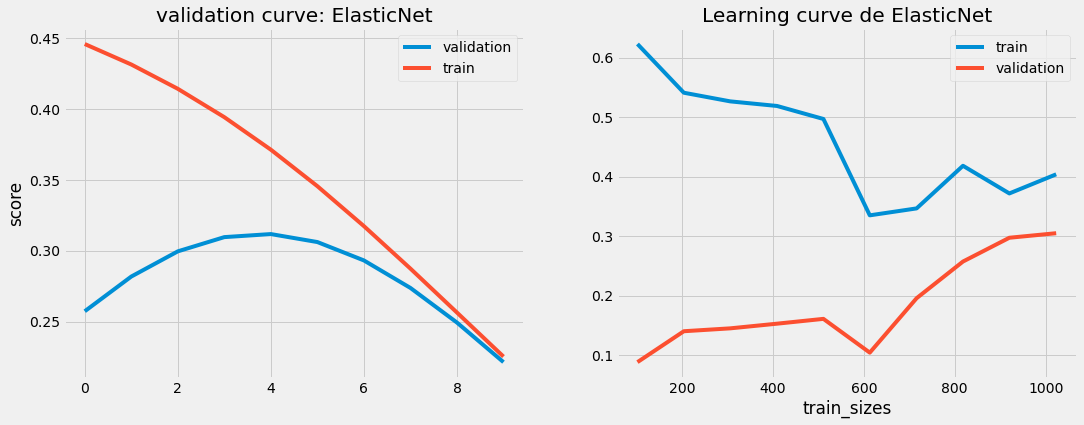

In [217]:
fig = plt.figure(1, figsize=(25, 6))
plt.subplot(131)
train_scores, valid_scores = validation_curve( ElasticNet(),X_train,  y_train, param_name="alpha", 
                                              param_range=np.logspace(0.1, 1, 10),cv=5)

plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('')
plt.title("validation curve: ElasticNet")
plt.legend()

plt.subplot(132)
model = elastic_grid.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve')
plt.legend()
plt.title('Learning curve de ElasticNet')
plt.legend()

#### Target: ``SiteEnergyUse(kBtu)``

In [126]:
#Le modèle Elastic Net comprend les modèles linéaires / ridge et lasso via les valeurs des coefficients dans le grid search CV
import warnings
warnings.filterwarnings('ignore')

score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}

kf = KFold(n_splits=5)
parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge


elastic_grid_s = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      scoring=score,
                      return_train_score = True,
                      refit='r2',
                      cv=kf,
                      verbose=1
                     )

elastic_grid_s.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             refit='r2', return_train_score=True,
             scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error),
                      'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False),
                      'r2': make_scorer(r2_score)},
             verbose=1)

In [135]:
# Définition d'un dataFrame dans lequel, je mets les modèles et les résultats des validations croisées
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation_s = resultValidation_s.append(pd.DataFrame({
    'Modèle' : ['Elastic Net'],
    'Best Param' : [elastic_grid_s.best_params_],
    'RMSE' : [min(elastic_grid_s.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(elastic_grid_s.cv_results_['mean_test_r2'])],
    'MAE' :  [min(elastic_grid_s.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [136]:
resultValidation_s

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},2.837045e+07,-0.029129,7.463001e+06
1,Elastic Net,"{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}",1.682627e+07,0.554723,5.448787e+06


Le modèle optimal a les caractéristiques suivantes:
- alpha = 0.0001 : le terme de régularisation Lasso (L1) est quasiment nul mais il ne s'agit pas de notre paramètre le plus faible dasn le grid search CV
- le terme l1_ratio est approximativement de 0.9, signifiant que le poids du L1 est plus important que celui du L2 dans la régularisation

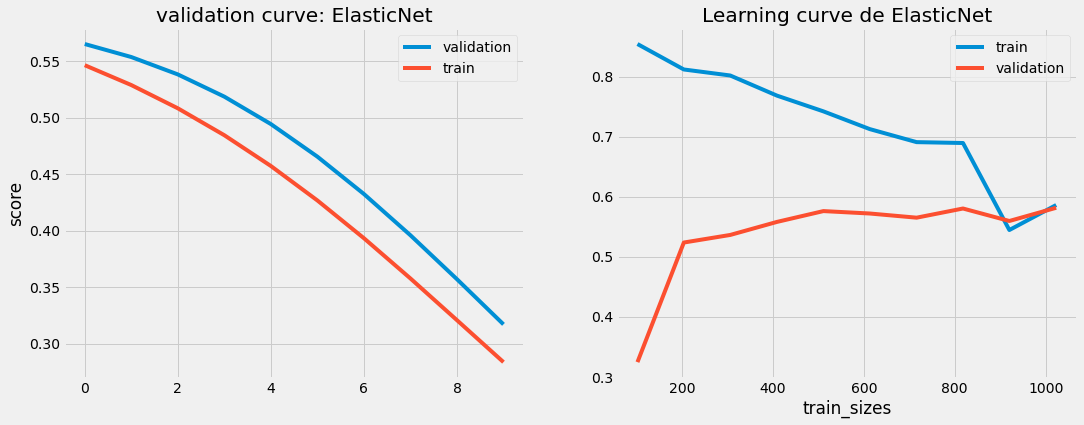

In [218]:
fig = plt.figure(1, figsize=(25, 6))
plt.subplot(131)
train_scores, valid_scores = validation_curve( ElasticNet(),X_train_s,  y_train_s, param_name="alpha", 
                                              param_range=np.logspace(0.1, 1, 10),cv=5)

plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('')
plt.title("validation curve: ElasticNet")
plt.legend()

plt.subplot(132)
model = elastic_grid_s.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model, X_train_s, y_train_s, train_sizes=np.linspace(0.1, 1, 10), cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve')
plt.legend()
plt.title('Learning curve de ElasticNet')
plt.legend()

### c/ Regression random Forest

#### Target: ``TotalGHGEmissions``

In [81]:
parameters = {
    'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'],#nombre de features observées pour chaque arbre
#    'metric': ['accuracy_score','f1_score']
}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
kf = KFold(n_splits=5)
rfr_search = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                               scoring=score,
                               return_train_score = True,
                               refit='r2',
                               cv=kf,
                               verbose=1)
rfr_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             refit='r2', return_train_score=True,
             scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error),
                      'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False),
                      'r2': make_scorer(r2_score)},
             verbose=1)

In [146]:
rfr_search.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

In [137]:
# Enregistrement de nos résultats dans le tableau des résultats de validations croisées
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation = resultValidation.append(pd.DataFrame({
    'Modèle' : ['RdForest'],
    'Best Param' : [rfr_search.best_params_],
    'RMSE' : [min(rfr_search.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(rfr_search.cv_results_['mean_test_r2'])],
    'MAE' :  [min(rfr_search.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [138]:
resultValidation

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},725.246664,-0.006916,167.702211
1,Elastic Net,"{'alpha': 1, 'l1_ratio': 0.9, 'tol': 0.0001}",536.937051,0.399772,163.465150
2,RdForest,"{'max_features': 'auto', 'min_samples_leaf': 1...",526.986182,0.474163,128.703727


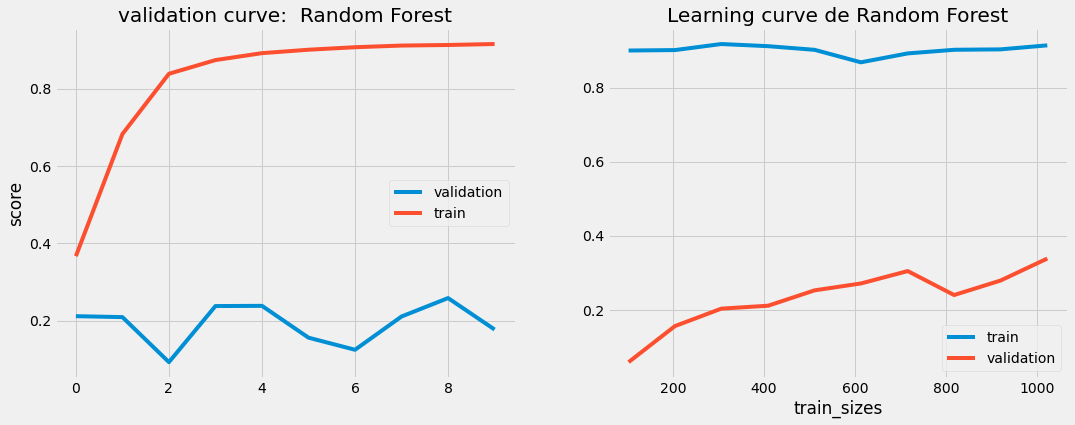

In [219]:
fig = plt.figure(1, figsize=(25, 6))
rf = RandomForestRegressor(random_state=42)
plt.subplot(131)
train_scores, valid_scores = validation_curve(rf,X_train, y_train,
                                              param_name="max_depth",
                                              param_range=np.arange(1, 11), cv=5)
plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel(' ')
plt.title("validation curve:  Random Forest")
plt.legend()

plt.subplot(132)
model_forest = rfr_search.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model_forest, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)
#print(train_sizes)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve de Random Forest')
plt.legend()

#### Target: ``SiteEnergyUse(kBtu)``

In [84]:
parameters = {
    'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'],#nombre de features observées pour chaque arbre
#    'metric': ['accuracy_score','f1_score']
}
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
kf = KFold(n_splits=5)
rfr_search_s = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                               scoring=score,
                               return_train_score = True,
                               refit='r2',
                               cv=kf,
                               verbose=1)
rfr_search_s.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             refit='r2', return_train_score=True,
             scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error),
                      'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False),
                      'r2': make_scorer(r2_score)},
             verbose=1)

In [139]:
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation_s = resultValidation_s.append(pd.DataFrame({
    'Modèle' : ['RdForest'],
    'Best Param' : [rfr_search_s.best_params_],
    'RMSE' : [min(rfr_search_s.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(rfr_search_s.cv_results_['mean_test_r2'])],
    'MAE' :  [min(rfr_search_s.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [141]:
resultValidation_s

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},2.837045e+07,-0.029129,7.463001e+06
1,Elastic Net,"{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}",1.682627e+07,0.554723,5.448787e+06
2,RdForest,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",2.083421e+07,0.513895,4.600569e+06


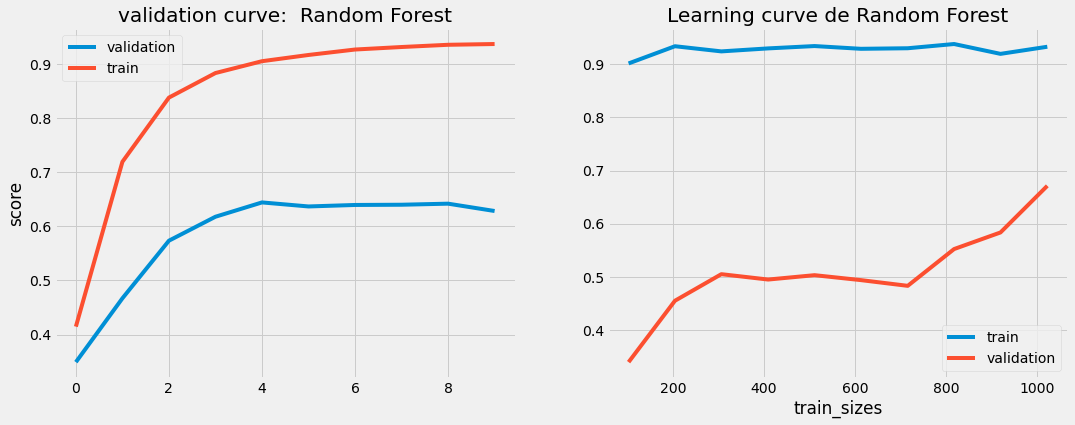

In [220]:
fig = plt.figure(1, figsize=(25, 6))
rf = RandomForestRegressor(random_state=42)
plt.subplot(131)
train_scores, valid_scores = validation_curve(rf,X_train_s, y_train_s,
                                              param_name="max_depth",
                                              param_range=np.arange(1, 11), cv=5)
plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel(' ')
plt.title("validation curve:  Random Forest")
plt.legend()

plt.subplot(132)
model_forest = rfr_search_s.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model_forest, X_train_s, y_train_s, train_sizes=np.linspace(0.1, 1, 10), cv=5)
#print(train_sizes)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve de Random Forest')
plt.legend()

### d/ Support vector regression

#### Target: ``TotalGHGEmissions``

In [87]:
parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
kf = KFold(n_splits=5)

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring=score,
                      return_train_score = True,
                      refit='r2',
                      cv=kf,
                   verbose=1)

svm.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             refit='r2', return_train_score=True,
             scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error),
                      'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False),
                      'r2': make_scorer(r2_score)},
             verbose=1)

In [88]:
svm.best_params_

{'C': 10, 'epsilon': 1, 'gamma': 0.01}

In [150]:
# Enregistrement de nos résultats dans le tableau des résultats de validations croisées
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation = resultValidation.append(pd.DataFrame({
    'Modèle' : ['SVM '],
    'Best Param' : [svm.best_params_],
    'RMSE' : [min(svm.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(svm.cv_results_['mean_test_r2'])],
    'MAE' :  [min(svm.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [151]:
resultValidation

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},725.246664,-0.006916,167.702211
1,Elastic Net,"{'alpha': 1, 'l1_ratio': 0.9, 'tol': 0.0001}",536.937051,0.399772,163.465150
2,RdForest,"{'max_features': 'auto', 'min_samples_leaf': 1...",526.986182,0.474163,128.703727
3,SVM,"{'C': 10, 'epsilon': 1, 'gamma': 0.01}",724.907742,0.002110,154.625111


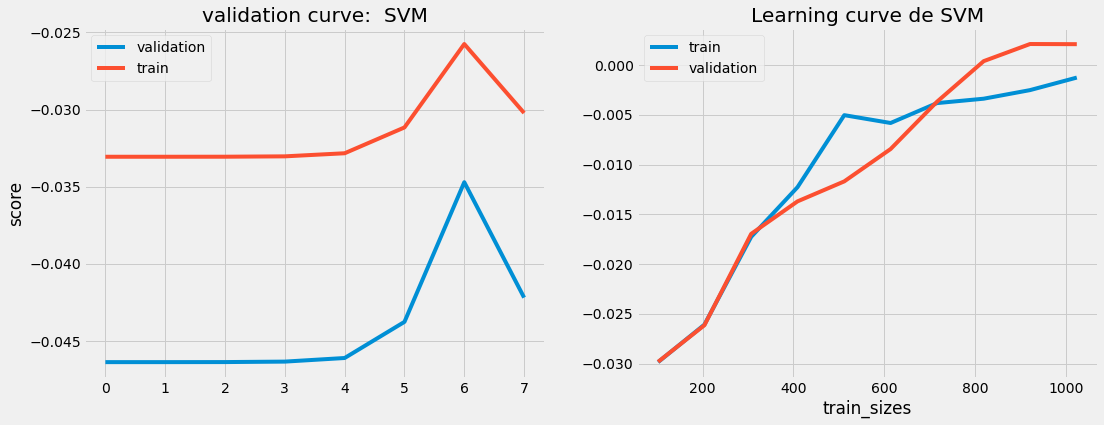

In [148]:
fig = plt.figure(1, figsize=(25, 6))
#rf = SVR(random_state=42)
plt.subplot(131)
train_scores, valid_scores = validation_curve(SVR(),X_train, y_train,
                                              param_name="gamma",
                                              param_range=[1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], cv=5)
plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel(' ')
plt.title("validation curve:  SVM")
plt.legend()

plt.subplot(132)
model_svm = svm.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model_svm, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)
#print(train_sizes)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve de SVM')
plt.legend()

#### Target: ``SiteEnergyUse(kBtu)``

In [91]:
parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation
kf = KFold(n_splits=5)
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
svm_s = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring=score,
                      return_train_score = True,
                      refit='r2',
                      cv=kf,
                   verbose=1)

svm_s.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             refit='r2', return_train_score=True,
             scoring={'neg_mean_absolute_error': make_scorer(mean_absolute_error),
                      'neg_root_mean_squared_error': make_scorer(mean_squared_error, squared=False),
                      'r2': make_scorer(r2_score)},
             verbose=1)

In [143]:
# Enregistrement de nos résultats dans le tableau des résultats de validations croisées
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation_s = resultValidation_s.append(pd.DataFrame({
    'Modèle' : ['SVM '],
    'Best Param' : [svm_s.best_params_],
    'RMSE' : [min(svm_s.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(svm_s.cv_results_['mean_test_r2'])],
    'MAE' :  [min(svm_s.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [146]:
resultValidation_s

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},2.837045e+07,-0.029129,7.463001e+06
1,Elastic Net,"{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}",1.682627e+07,0.554723,5.448787e+06
2,RdForest,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",2.083421e+07,0.513895,4.600569e+06
3,SVM,"{'C': 10, 'epsilon': 0.001, 'gamma': 0.01}",2.888364e+07,-0.065304,7.462923e+06


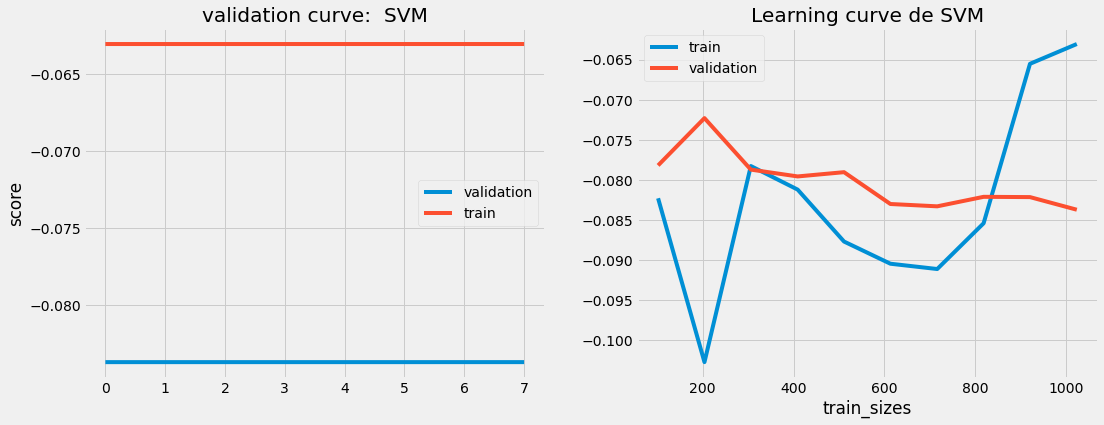

In [222]:
fig = plt.figure(1, figsize=(25, 6))
#rf = SVR(random_state=42)
plt.subplot(131)
train_scores, valid_scores = validation_curve(SVR(),X_train_s, y_train_s,
                                              param_name="gamma",
                                              param_range=[1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], cv=5)
plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel(' ')
plt.title("validation curve:  SVM")
plt.legend()

plt.subplot(132)
model_svm = svm.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model_svm, X_train_s, y_train_s, train_sizes=np.linspace(0.1, 1, 10), cv=5)
#print(train_sizes)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve de SVM')
plt.legend()

### e/ XG Boost

#### Target: ``TotalGHGEmissions``

In [120]:
from xgboost import XGBRegressor

parameters = {'n_estimators': [100,200,500,1000], 
                        'max_depth': [4,5,6,7,8],                       
                        'learning_rate': [0.01,0.1],   
                        'subsample': [0.9,0.5,0.1]
                       }


score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
kf = KFold(n_splits=5)
xgb_grid = GridSearchCV(XGBRegressor(),
                        param_grid = parameters,
                        scoring=score,
                        return_train_score = True,
                        refit='r2',
                        cv=kf,
                        verbose=1)
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_wei...
                                    validate_parameters=None, verbosity=None),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             refit='

In [183]:
xgb_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}

In [153]:
# Enregistrement de nos résultats dans le tableau des résultats de validations croisées
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation = resultValidation.append(pd.DataFrame({
    'Modèle' : ['XGBOOST'],
    'Best Param' : [xgb_grid.best_params_],
    'RMSE' : [min(xgb_grid.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(xgb_grid.cv_results_['mean_test_r2'])],
    'MAE' :  [min(xgb_grid.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [154]:
resultValidation

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},725.246664,-0.006916,167.702211
1,Elastic Net,"{'alpha': 1, 'l1_ratio': 0.9, 'tol': 0.0001}",536.937051,0.399772,163.465150
2,RdForest,"{'max_features': 'auto', 'min_samples_leaf': 1...",526.986182,0.474163,128.703727
3,SVM,"{'C': 10, 'epsilon': 1, 'gamma': 0.01}",724.907742,0.002110,154.625111
4,XGBOOST,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",523.043204,0.472865,127.525132


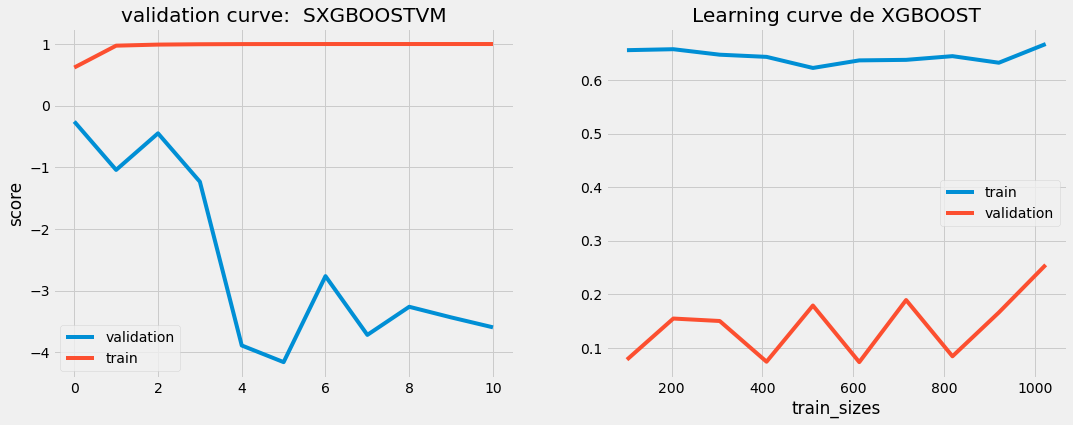

In [223]:
fig = plt.figure(1, figsize=(25, 6))
#rf = SVR(random_state=42)
plt.subplot(131)
train_scores, valid_scores = validation_curve(XGBRegressor(),X_train, y_train,
                                              param_name="max_depth",
                                              param_range=np.arange(1, 12), cv=5)
plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel(' ')
plt.title("validation curve:  SXGBOOSTVM")
plt.legend()

plt.subplot(132)
model_svm = xgb_grid.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model_svm, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)
#print(train_sizes)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve de XGBOOST')
plt.legend()

#### Target: ``SiteEnergyUse(kBtu)``

In [123]:

parameters = {'n_estimators': [100,200,500,1000], 
                        'max_depth': [4,5,6,7,8],                       
                        'learning_rate': [0.01,0.1],   
                        'subsample': [0.9,0.5,0.1]
                       }
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}
kf = KFold(n_splits=5)
xgb_grid_s = GridSearchCV(XGBRegressor(),
                        param_grid = parameters,
                        scoring=score,
                        return_train_score = True,
                        refit='r2',
                        cv=kf,
                        verbose=1)
xgb_grid_s.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_wei...
                                    validate_parameters=None, verbosity=None),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             refit='

In [155]:
# Il y a les meilleurs paramètres, la rmse, la mae et la r2
resultValidation_s = resultValidation_s.append(pd.DataFrame({
    'Modèle' : ['XGBOOST'],
    'Best Param' : [xgb_grid_s.best_params_],
    'RMSE' : [min(xgb_grid_s.cv_results_['mean_test_neg_root_mean_squared_error'])],
    'R2' :   [max(xgb_grid_s.cv_results_['mean_test_r2'])],
    'MAE' :  [min(xgb_grid_s.cv_results_['mean_test_neg_mean_absolute_error'])]

}),
                         
              ignore_index=True)

In [156]:
resultValidation_s

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},2.837045e+07,-0.029129,7.463001e+06
1,Elastic Net,"{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}",1.682627e+07,0.554723,5.448787e+06
2,RdForest,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",2.083421e+07,0.513895,4.600569e+06
3,SVM,"{'C': 10, 'epsilon': 0.001, 'gamma': 0.01}",2.888364e+07,-0.065304,7.462923e+06
4,XGBOOST,"{'learning_rate': 0.01, 'max_depth': 8, 'n_est...",2.093185e+07,0.483586,4.517141e+06


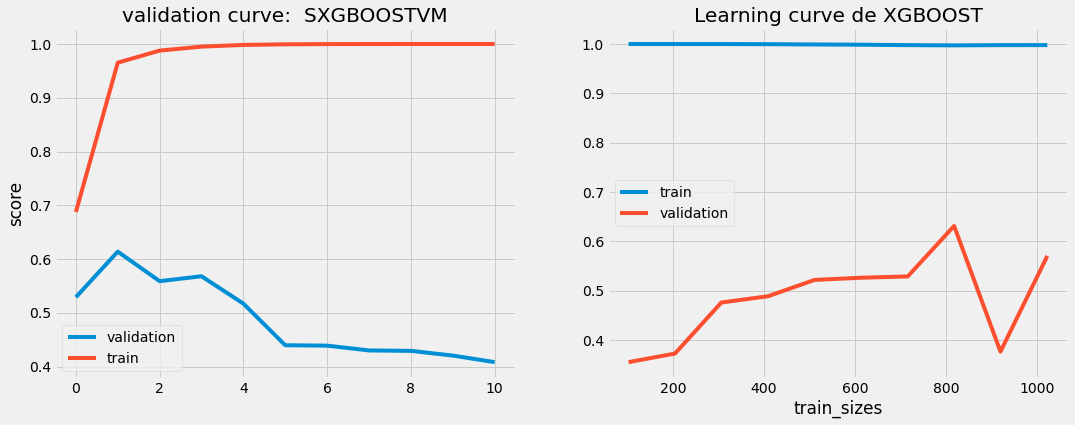

In [224]:
fig = plt.figure(1, figsize=(25, 6))
#rf = SVR(random_state=42)
plt.subplot(131)
train_scores, valid_scores = validation_curve(XGBRegressor(),X_train_s, y_train_s,
                                              param_name="max_depth",
                                              param_range=np.arange(1, 12), cv=5)
plt.plot(valid_scores.mean(axis=1), label='validation')
plt.plot(train_scores.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel(' ')
plt.title("validation curve:  SXGBOOSTVM")
plt.legend()

plt.subplot(132)
model_svm = xgb_grid_s.best_estimator_
train_sizes, train_scores, valid_scores = learning_curve(model_svm, X_train_s, y_train_s, train_sizes=np.linspace(0.1, 1, 10), cv=5)
#print(train_sizes)
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve de XGBOOST')
plt.legend()

### 3.2 Evaluation des modèles optimisés sur les jeux d'entrainements

#### Target: ``TotalGHGEmissions``

In [343]:
resultValidation

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},676.018285,-0.038429,159.415477
1,Elastic Net,"{'alpha': 10, 'l1_ratio': 0.6000000000000001, ...",547.805294,0.157505,154.906167
2,RdForest,"{'max_features': 'auto', 'min_samples_leaf': 5...",498.096743,0.390913,125.083901
3,SVM,"{'C': 10, 'epsilon': 1, 'gamma': 0.01}",671.028311,0.013017,145.492304
4,XGBOOST,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",582.474316,0.124048,137.053861


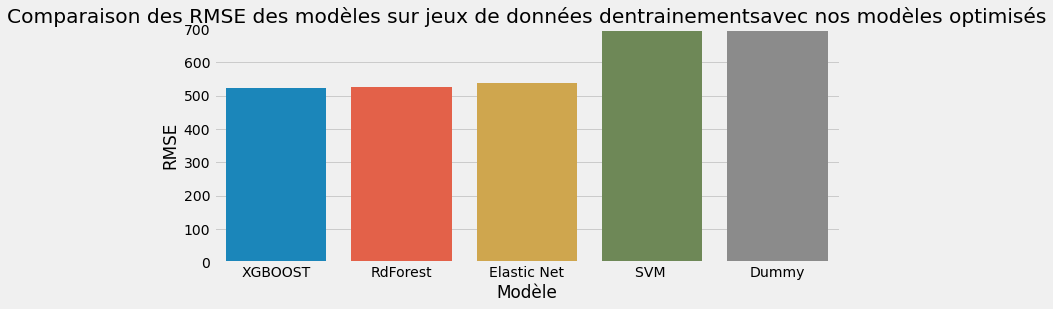

In [157]:
# RMSE
plt.figure(figsize=(10,4))
labels = resultValidation["Modèle"]
chart = sns.barplot(x = labels,y = resultValidation["RMSE"],order=resultValidation.sort_values('RMSE').Modèle)
plt.title('Comparaison des RMSE des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([0,700])
plt.show()

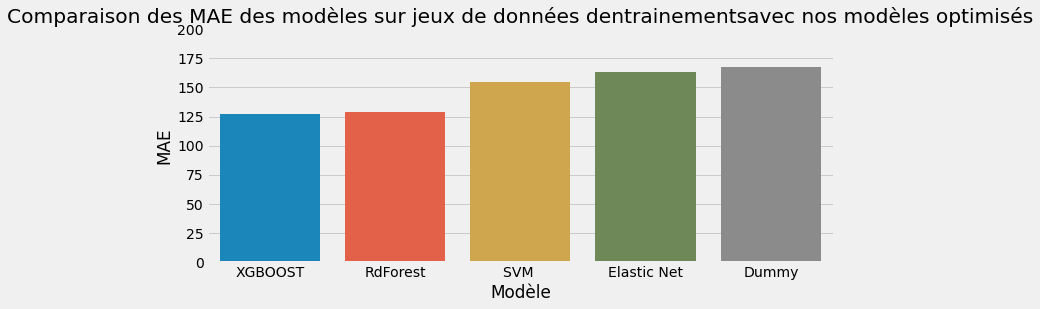

In [158]:
#MAE
plt.figure(figsize=(10,4))
labels = resultValidation["Modèle"]
chart = sns.barplot(x = labels,y = resultValidation["MAE"],order=resultValidation.sort_values('MAE').Modèle)
plt.title('Comparaison des MAE des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([0,200])
plt.show()

In [227]:
resultValidation_s

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},2.119695e+07,-0.004658,6.868329e+06
1,Elastic Net,"{'alpha': 1, 'l1_ratio': 0.7000000000000001, '...",1.407553e+07,0.581688,4.807309e+06
2,RdForest,"{'max_features': 'auto', 'min_samples_leaf': 1...",1.245056e+07,0.682193,3.709011e+06
3,SVM,"{'C': 10, 'epsilon': 0.001, 'gamma': 0.01}",2.191065e+07,-0.083715,6.868253e+06
4,XGBOOST,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",1.390253e+07,0.571854,3.766517e+06


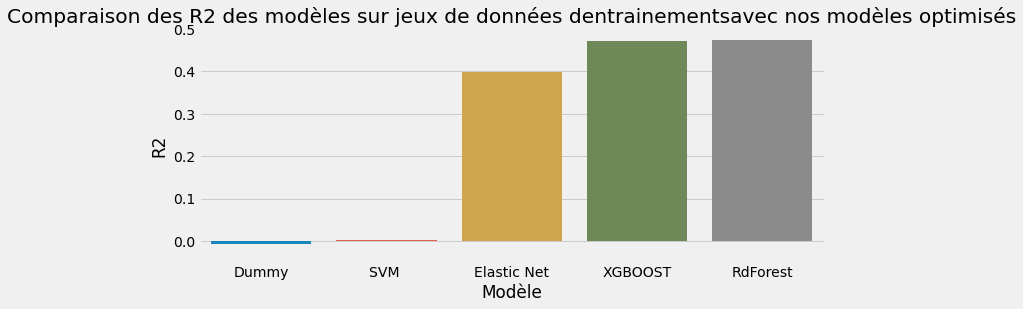

In [159]:
# R2
plt.figure(figsize=(10,4))
labels = resultValidation["Modèle"]
chart = sns.barplot(x = labels,y = resultValidation["R2"],order=resultValidation.sort_values('R2').Modèle)
plt.title('Comparaison des R2 des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([-0.05,0.5])
plt.show()

#### Target: ``SiteEnergyUse(kBtu)``

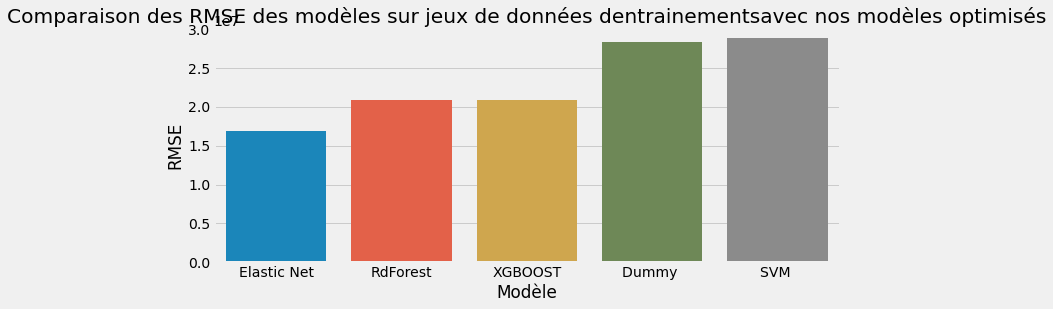

In [160]:
# RMSE
plt.figure(figsize=(10,4))
labels = resultValidation_s["Modèle"]
chart = sns.barplot(x = labels,y = resultValidation_s["RMSE"],order=resultValidation_s.sort_values('RMSE').Modèle)
plt.title('Comparaison des RMSE des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([0,3*10**7])
plt.show()

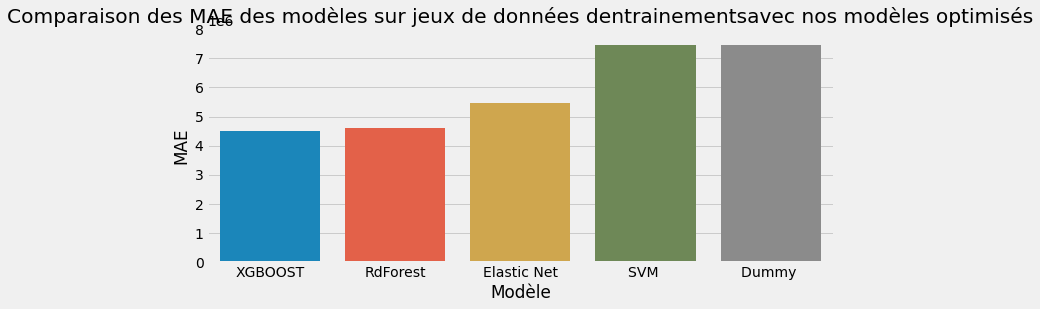

In [161]:
#MAE
plt.figure(figsize=(10,4))
labels = resultValidation_s["Modèle"]
chart = sns.barplot(x = labels,y = resultValidation_s["MAE"],order=resultValidation_s.sort_values('MAE').Modèle)
plt.title('Comparaison des MAE des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([0,0.8*10**7])
plt.show()

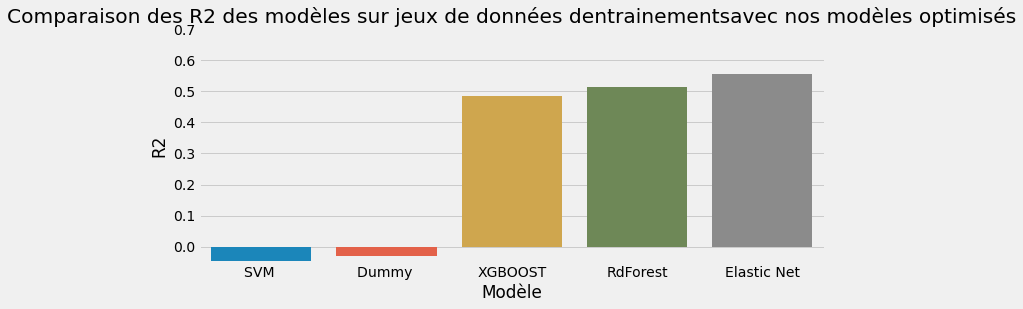

In [162]:
# R2
plt.figure(figsize=(10,4))
labels = resultValidation_s["Modèle"]
chart = sns.barplot(x = labels,y = resultValidation_s["R2"],order=resultValidation_s.sort_values('R2').Modèle)
plt.title('Comparaison des R2 des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([-0.05,0.7])
plt.show()

### Export du modèle pour une utilisation ultérieure

In [264]:
# Target TotalGHGEmissions
dict_modeles = {
    'Dummy': dummy_grid.best_estimator_,
    'Elastic Net': elastic_grid.best_estimator_,
    'Random Forest Regressor' : rfr_search.best_estimator_,
    'SVM' : svm.best_estimator_,
    'XGBoost' : xgb_grid.best_estimator_,
}

# Target SiteEnergyUse(kBtu)
dict_modeles_s = {
    'Dummy_s': dummy_grid_s.best_estimator_,
    'Elastic Net_s': elastic_grid_s.best_estimator_,
    'Random Forest Regressor_s' : rfr_search_s.best_estimator_,
    'SVM_s' : svm_s.best_estimator_,
    'XGBoost_s' : xgb_grid_s.best_estimator_,
}

In [265]:
import pickle
#Target TotalGHGEmissions
for nom, model in dict_modeles.items():
    filename = 'models/' + nom + '.obj' 
    with  open(filename, 'wb') as filehandler :
        pickle.dump(model, filehandler)
        
# Target SiteEnergyUse
for nom, model in dict_modeles_s.items():
    filename_s = 'models/' + nom + '.obj' 
    with  open(filename_s, 'wb') as filehandler :
        pickle.dump(model, filehandler)

In [266]:
#Export du one hot encoder

with  open('models/onehotencoder.obj', 'wb') as filehandler :
    pickle.dump(ohe, filehandler)
    
#export du standardscaler
with  open('models/standardscaler.obj', 'wb') as filehandler :
    pickle.dump(ss, filehandler)

NameError: name 'ss' is not defined

### Chargement des modèles

In [267]:
import glob
import pickle

dict_modeles_new = dict_modeles
dict_modeles_new = {}

for filename in glob.glob('models/*'):
    if filename not in ['models\onehotencoder.obj', 'models\standardscaler.obj']:
        with open(filename, 'rb') as filehandler:
            print(filename)
            dict_modeles_new[str(filename)] = pickle.load(filehandler)
            
dict_modeles_new_s = dict_modeles_s
dict_modeles_new_s = {}

for filename_s in glob.glob('models_s/*'):
    if filename not in ['models\onehotencoder.obj', 'models\standardscaler.obj']:
        with open(filename_s, 'rb') as filehandler:
            print(filename_s)
            dict_modeles_new_s[str(filename_s)] = pickle.load(filehandler)

models\Dummy.obj
models\Dummy_s.obj
models\Elastic Net.obj
models\Elastic Net_s.obj
models\Random Forest Regressor.obj
models\Random Forest Regressor_s.obj
models\SVM.obj
models\SVM_s.obj
models\XGBoost.obj
models\XGBoost_s.obj


# 4. Prédiction sur les données de test et évaluation des performances de nos modèles sur le jeu de test <a class="anchor" id="partie4"></a>

## 4.1 Features importantes

-  On peut voit l'importance des meilleurs features qu'on peut utiliser...

In [ ]:
### Target: ``EmissionTotalGHG``

In [104]:
model = RandomForestRegressor(n_estimators = 500, max_features='sqrt', max_depth=20, random_state= 42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=500,
                      random_state=42)

In [105]:
importances = model.feature_importances_

Text(0.5, 0, 'Relative Importance')

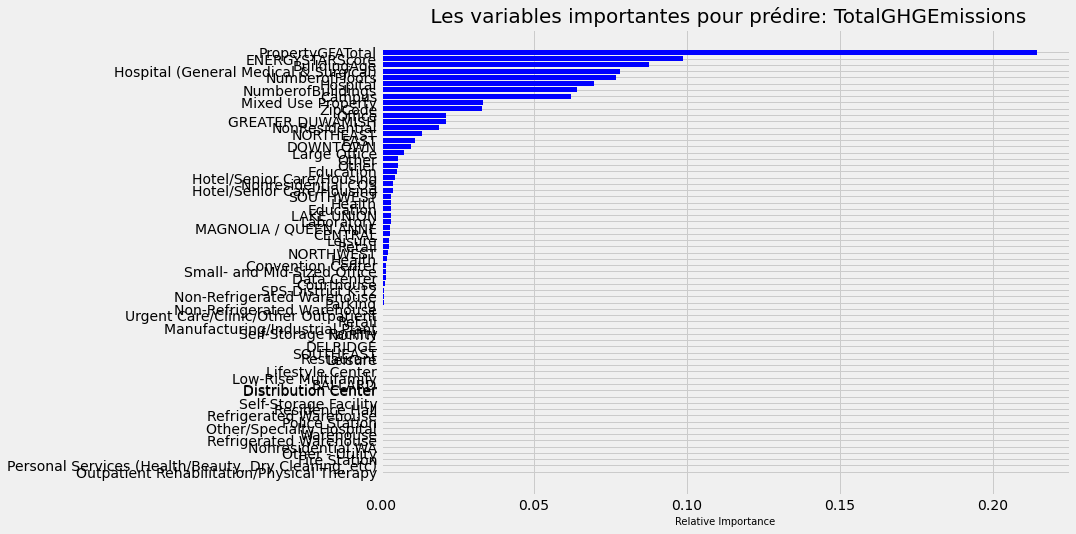

In [106]:
indices = np.argsort(importances)
# style du graphique 
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,8)) 
plt.title(' Les variables importantes pour prédire: TotalGHGEmissions', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance', fontsize=10)

### Target: ``SiteEnergyUse(kBtu)``

In [154]:
model_s = RandomForestRegressor(n_estimators = 500, max_features='sqrt', max_depth=20, random_state= 42)
model_s.fit(X_train_s, y_train_s)
importances_s = model_s.feature_importances_
indices_s = np.argsort(importances_s)

Text(0.5, 0, 'Relative Importance')

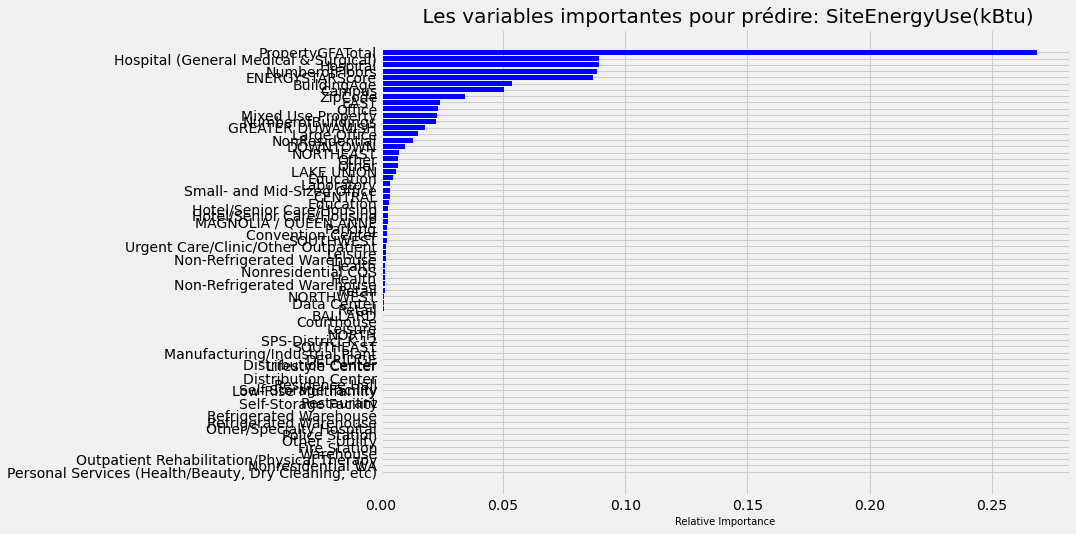

In [155]:
# style du graphique 
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,8)) 
plt.title(' Les variables importantes pour prédire: SiteEnergyUse(kBtu)', fontsize=20)
plt.barh(range(len(indices_s)), importances_s[indices_s], color='b', align='center')
plt.yticks(range(len(indices_s)), [liste_variables[i] for i in indices_s])
plt.xlabel('Relative Importance', fontsize=10)

## 4.2 Prédiction sur les données de test et évaluation de performances de nos modèles <a class="anchor" id="partie4_2"></a>

- Les prédictions sur les jeux de tests sont évalués par les metriques RMSE, MAE et R2 pour nos 2 targets

#### a/ Comparaison des modèles sur à partir des métriques

#### Target: ``TotalGHGEmissions``

In [163]:
# On enregistre directement l'ensemble de nos résultats dans un tableau
import math
results_score = pd.DataFrame({})

# Résultats des prédiction à partir du modèle de Baseline
results_score = results_score.append(pd.DataFrame({
    'Modèle' : ['Dummy - Baseline'],
    'Best Param' : [dummy_grid.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test, dummy_grid.predict(X_test))) ],
    'Score_R2' :   [r2_score(y_test,  dummy_grid.predict(X_test))],
    'Score_MAE' :  [mean_absolute_error(y_test,  dummy_grid.predict(X_test))]

}),ignore_index=True)

# Résultats des prédiction à partir du modèle de Baseline
results_score = results_score.append(pd.DataFrame({
    'Modèle' : ['Elasticnet Regression'],
    'Best Param' : [elastic_grid.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test, elastic_grid.predict(X_test)))],
    'Score_R2' :   [r2_score(y_test, elastic_grid.predict(X_test))],
    'Score_MAE' :  [mean_absolute_error(y_test, elastic_grid.predict(X_test))]
}),ignore_index=True)

# Résultats des prédiction à partir du modèle de Random Forest
results_score = results_score.append(pd.DataFrame({
    'Modèle' : ['Random Forest Regressor'],
    'Best Param' : [rfr_search.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test,rfr_search.predict(X_test)))],
    'Score_R2' :   [r2_score(y_test,rfr_search.predict(X_test))],
    'Score_MAE' :  [mean_absolute_error(y_test,rfr_search.predict(X_test))]
}),
              ignore_index=True)

# Résultats des prédiction à partir du modèle de SVM
results_score = results_score.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Best Param' : [svm.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test,svm.predict(X_test) ))],
    'Score_R2' :   [r2_score(y_test,svm.predict(X_test))],
    'Score_MAE' :  [mean_absolute_error(y_test,svm.predict(X_test))]
}),
              ignore_index=True)

# Résultats des prédiction à partir du modèle de GradientBoost
results_score = results_score.append(pd.DataFrame({
    'Modèle' : ['XGBoost'],
    'Best Param' : [xgb_grid.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test,xgb_grid.predict(X_test) ))],
    'Score_R2' :   [r2_score(y_test,xgb_grid.predict(X_test))],
    'Score_MAE' :  [mean_absolute_error(y_test,xgb_grid.predict(X_test))]
}),
              ignore_index=True)

In [164]:
results_score

,Modèle,Best Param,Score_RMSE,Score_R2,Score_MAE
0,Dummy - Baseline,{'strategy': 'mean'},651.116025,-0.001223,196.793647
1,Elasticnet Regression,"{'alpha': 1, 'l1_ratio': 0.9, 'tol': 0.0001}",440.650750,0.541433,153.617349
2,Random Forest Regressor,"{'max_features': 'auto', 'min_samples_leaf': 1...",312.604333,0.769217,107.263866
3,Support Vector Machine,"{'C': 10, 'epsilon': 1, 'gamma': 0.01}",648.706828,0.006172,128.170537
4,XGBoost,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",394.173801,0.633064,116.702478


La RMSE relative des meilleurs modèles est de 3,0 % (racine de l'erreur quadratique moyenne ramenée à la valeur à prédire), c'est une performance remarquable.

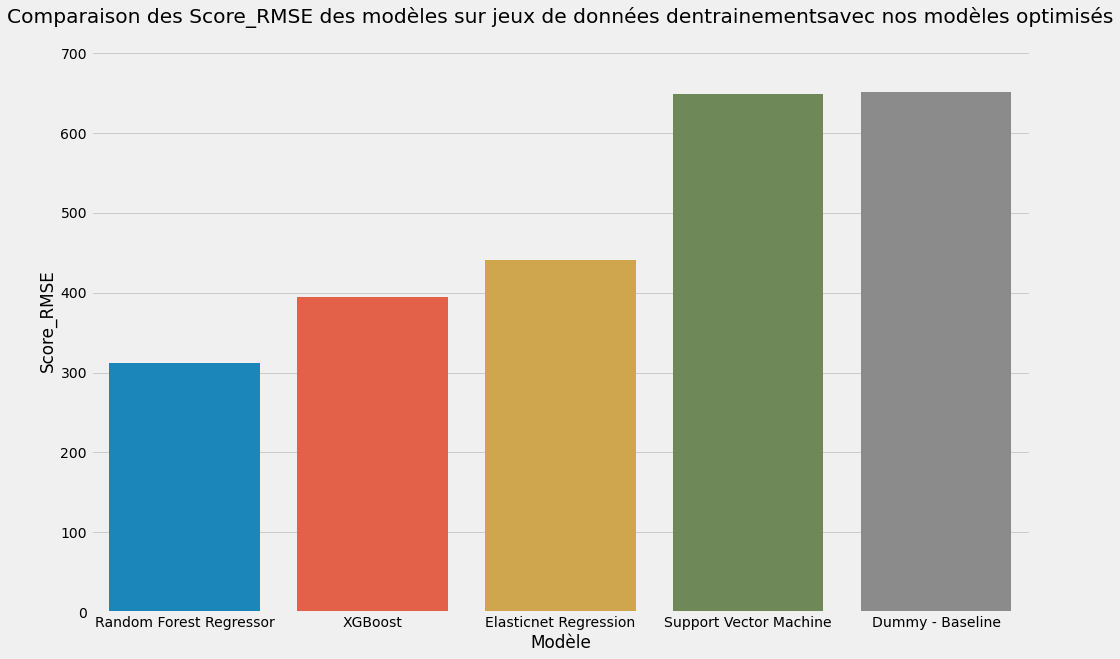

In [165]:
# Comparaison des RMSE 
plt.figure(figsize=(15,10))
labels = results_score["Modèle"]
chart = sns.barplot(x = labels,y = results_score["Score_RMSE"],order=results_score.sort_values('Score_RMSE').Modèle)
plt.title('Comparaison des Score_RMSE des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([-0.05,730])
plt.show()

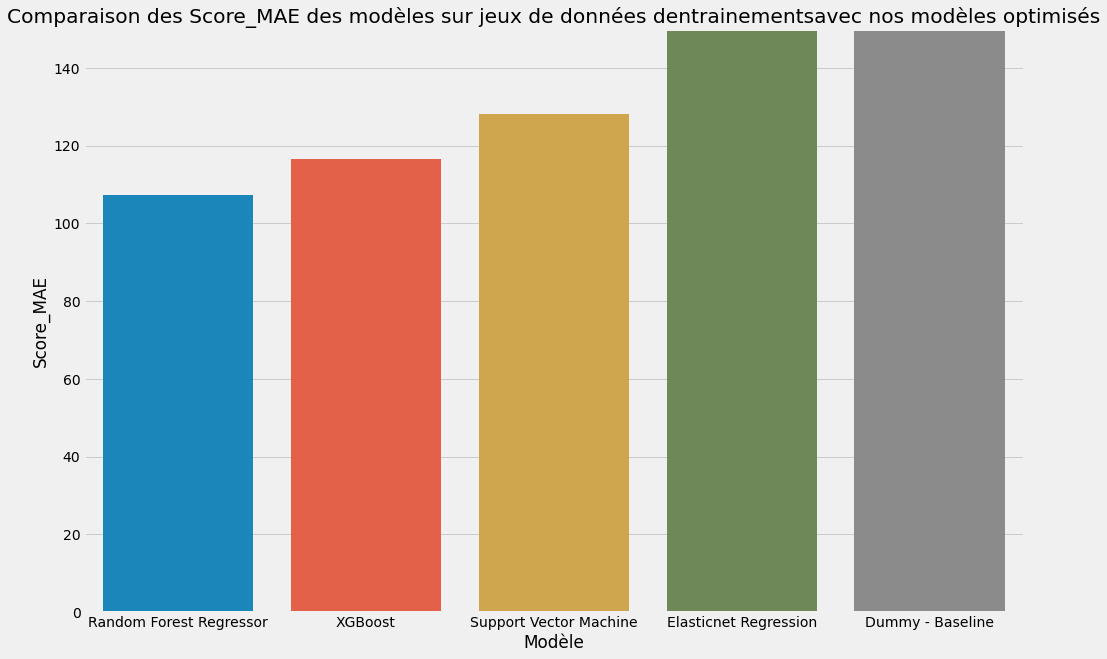

In [168]:
# Comparaison des MAE
plt.figure(figsize=(15,10))
labels = results_score["Modèle"]
chart = sns.barplot(x = labels,y = results_score["Score_MAE"],order=results_score.sort_values('Score_MAE').Modèle)
plt.title('Comparaison des Score_MAE des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([-0.05,150])
plt.show()

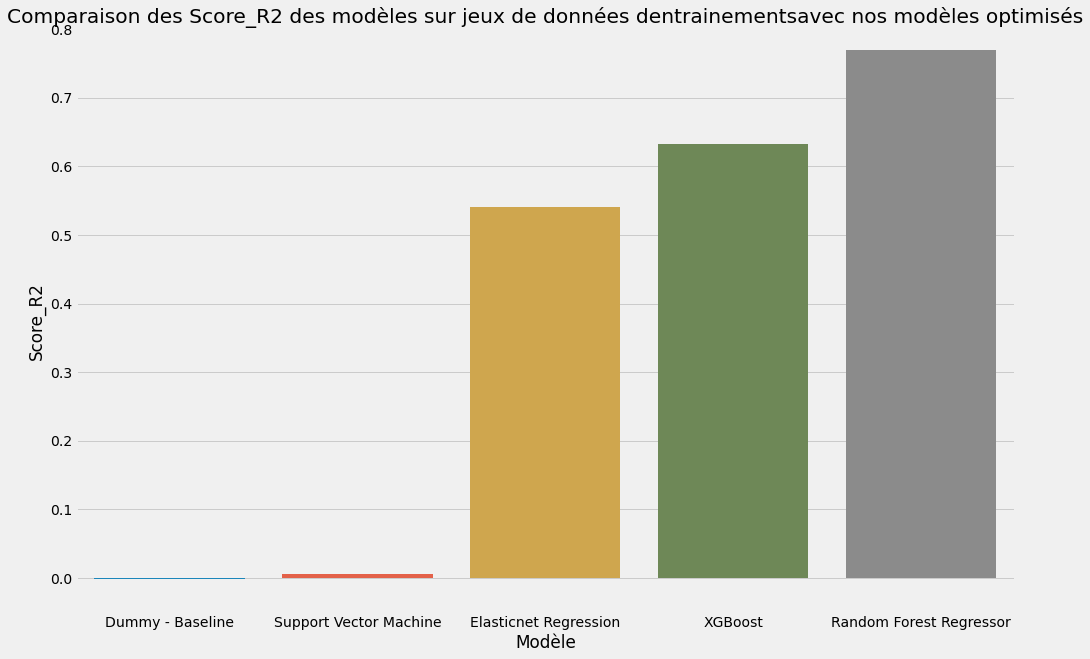

In [169]:
# Comparaison des R2 
plt.figure(figsize=(15,10))
labels = results_score["Modèle"]
chart = sns.barplot(x = labels,y = results_score["Score_R2"],order=results_score.sort_values('Score_R2').Modèle)
plt.title('Comparaison des Score_R2 des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([-0.05,0.8])
plt.show()

#### Target: ``SiteEnergyUse``

In [170]:
# On enregistre directement l'ensemble de nos résultats dans un tableau
import math
results_score_s = pd.DataFrame({})

# Résultats des prédiction à partir du modèle de Baseline
results_score_s = results_score_s.append(pd.DataFrame({
    'Modèle' : ['Dummy - Baseline'],
    'Best Param' : [dummy_grid_s.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test_s, dummy_grid_s.predict(X_test_s))) ],
    'Score_R2' :   [r2_score(y_test_s,  dummy_grid_s.predict(X_test_s))],
    'Score_MAE' :  [mean_absolute_error(y_test_s,  dummy_grid_s.predict(X_test_s))]

}),ignore_index=True)

# Résultats des prédiction à partir du modèle de Baseline
results_score_s = results_score_s.append(pd.DataFrame({
    'Modèle' : ['Elasticnet Regression'],
    'Best Param' : [elastic_grid_s.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test_s, elastic_grid_s.predict(X_test_s)))],
    'Score_R2' :   [r2_score(y_test_s, elastic_grid_s.predict(X_test_s))],
    'Score_MAE' :  [mean_absolute_error(y_test_s, elastic_grid_s.predict(X_test_s))]
}),ignore_index=True)

# Résultats des prédiction à partir du modèle de Random Forest
results_score_s = results_score_s.append(pd.DataFrame({
    'Modèle' : ['Random Forest Regressor'],
    'Best Param' : [rfr_search_s.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test_s,rfr_search_s.predict(X_test_s)))],
    'Score_R2' :   [r2_score(y_test_s,rfr_search_s.predict(X_test_s))],
    'Score_MAE' :  [mean_absolute_error(y_test_s,rfr_search_s.predict(X_test_s))]
}),
              ignore_index=True)

# Résultats des prédiction à partir du modèle de SVM
results_score_s = results_score_s.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Best Param' : [svm_s.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test_s,svm_s.predict(X_test_s) ))],
    'Score_R2' :   [r2_score(y_test_s,svm_s.predict(X_test_s))],
    'Score_MAE' :  [mean_absolute_error(y_test_s,svm_s.predict(X_test_s))]
}),
              ignore_index=True)

# Résultats des prédiction à partir du modèle de GradientBoost
results_score_s = results_score_s.append(pd.DataFrame({
    'Modèle' : ['XGBoost'],
    'Best Param' : [xgb_grid_s.best_params_],
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test_s,xgb_grid_s.predict(X_test_s) ))],
    'Score_R2' :   [r2_score(y_test_s,xgb_grid_s.predict(X_test_s))],
    'Score_MAE' :  [mean_absolute_error(y_test_s,xgb_grid_s.predict(X_test_s))]
}),
              ignore_index=True)

In [171]:
results_score_s 

,Modèle,Best Param,Score_RMSE,Score_R2,Score_MAE
0,Dummy - Baseline,{'strategy': 'mean'},1.585495e+07,-0.005105,8.443624e+06
1,Elasticnet Regression,"{'alpha': 0.1, 'l1_ratio': 0.4, 'tol': 0.0001}",1.053596e+07,0.556156,4.857446e+06
2,Random Forest Regressor,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",1.040778e+07,0.566890,3.981983e+06
3,Support Vector Machine,"{'C': 10, 'epsilon': 0.001, 'gamma': 0.01}",1.661759e+07,-0.104124,6.388047e+06
4,XGBoost,"{'learning_rate': 0.01, 'max_depth': 8, 'n_est...",8.643736e+06,0.701266,3.391709e+06


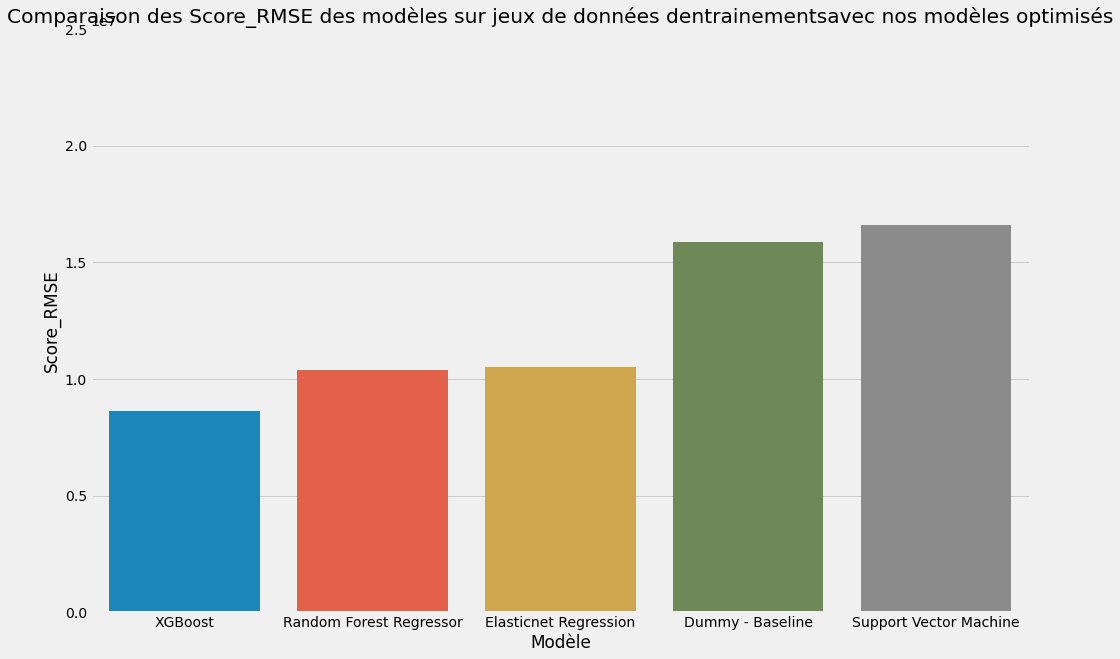

In [172]:
# Comparaison des RMSE 
plt.figure(figsize=(15,10))
labels = results_score_s["Modèle"]
chart = sns.barplot(x = labels,y = results_score_s["Score_RMSE"],order=results_score_s.sort_values('Score_RMSE').Modèle)
plt.title('Comparaison des Score_RMSE des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([-0.05,2.5*10**7])
plt.show()

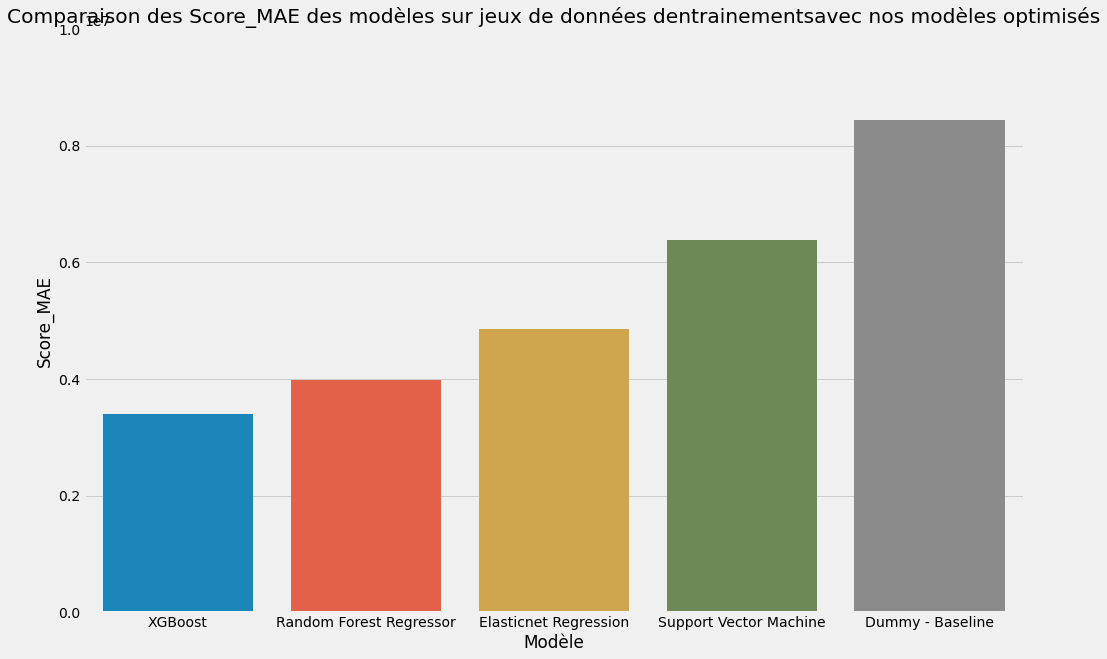

In [173]:
# Comparaison des MAE
plt.figure(figsize=(15,10))
labels = results_score_s["Modèle"]
chart = sns.barplot(x = labels,y = results_score_s["Score_MAE"],order=results_score_s.sort_values('Score_MAE').Modèle)
plt.title('Comparaison des Score_MAE des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([-0.05,1*10**7])
plt.show()

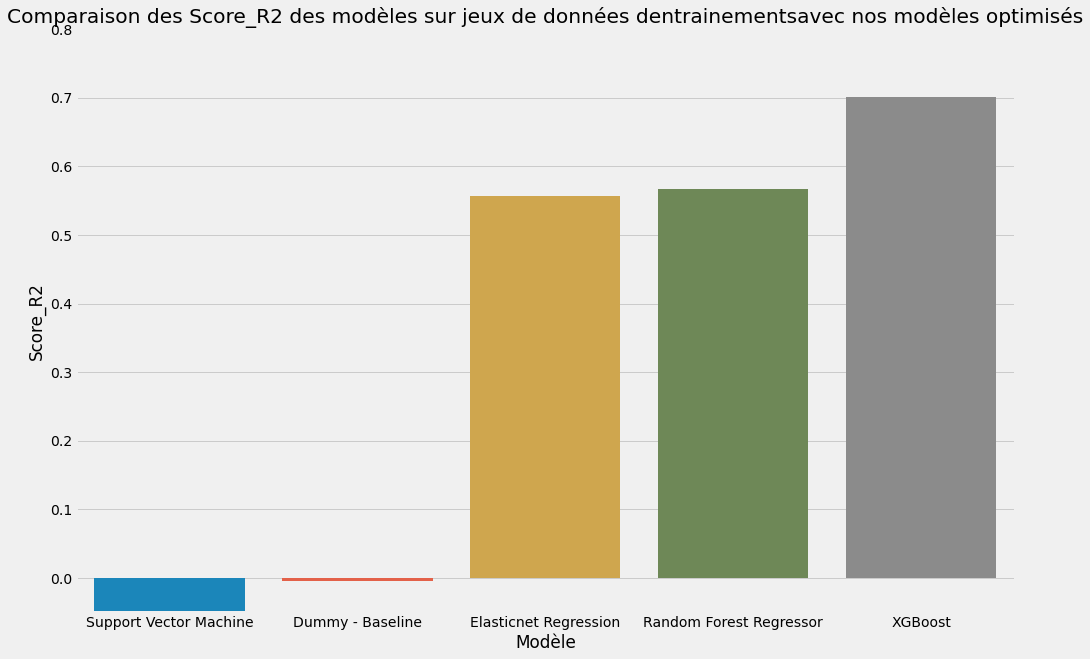

In [176]:
# Comparaison des R2 
plt.figure(figsize=(15,10))
labels = results_score_s["Modèle"]
chart = sns.barplot(x = labels,y = results_score_s["Score_R2"],order=results_score_s.sort_values('Score_R2').Modèle)
plt.title('Comparaison des Score_R2 des modèles sur jeux de données d''entrainements''avec nos modèles optimisés')

ax = plt.gca()
ax.set_ylim([-0.05,0.8])
plt.show()

- XGBoost et Random Forest Regressor sont les modèles avec la plus faible RMSE, avec une valeur très proche.

- Regardons quel algorithme est entraîné le plus rapidement et prédit le plus rapidement, pour voir lequel sélectionner pour les étapes suivantes

- Comparaison avec la RMSE pour un estimateur donnant la valeur moyenne

#### b/ Comparaison des modèles sur le temps d'estimation

#### Target: ``TotalGHGEmissions``

In [275]:
nom_modeles = ['Dummy','Elastic Net', 'Random Forest Regressor', 'SVM', 'XGBoost']
liste_modeles = [dict_modeles_new['models\Dummy.obj'],
                 dict_modeles_new['models\Elastic Net.obj'],
                 dict_modeles_new['models\Random Forest Regressor.obj'],
                 dict_modeles_new['models\SVM.obj'],
                 dict_modeles_new['models\XGBoost.obj']
                ]

In [276]:
i=0
for modele in liste_modeles:
    print(nom_modeles[i], ': ')
    i+=1
    %timeit modele.predict(X_train)
    print('')

Dummy : 
12.6 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Elastic Net : 
145 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Random Forest Regressor : 
13.5 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

SVM : 
226 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

XGBoost : 
2.62 ms ± 59.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



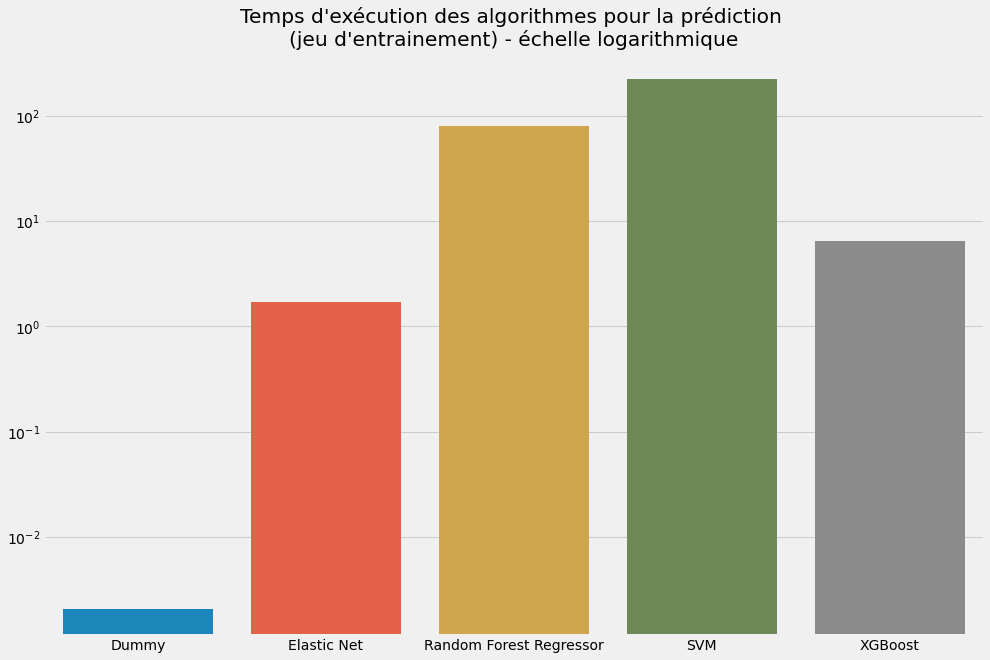

In [280]:
plt.figure(figsize=(15,10))
plt.title('Temps d\'exécution des algorithmes pour la prédiction \n(jeu d\'entrainement) - échelle logarithmique')
sns.barplot(x=nom_modeles,
           y = [0.0021,1.71, 79, 224, 6.41])
ax = plt.gca()
ax.set_yscale('log')

Le temps d'exécution de XGBoost est plus faible que celui de random forest , ça pourrait être un critère pour choisir éventuellement le XGBoost plutôt que le Random Forest Regressor (quite à dégrader légèrement la performance). 

### 4. Prédiction sur les données de test avec changement d'echelle (log)

Dans le notebook sur l'exploration, nous avons effectué un changemnt d'échelle de nos deux targets afin d'avoir des valeurs qui suivent bien une courbe normale. Nous allons donc voir est ce le fait de normaliser nos targets a un impact sur nos modèles.

In [293]:
test_co2 = np.log2(1+y_train)
test_site = np.log2(1+y_train_s)

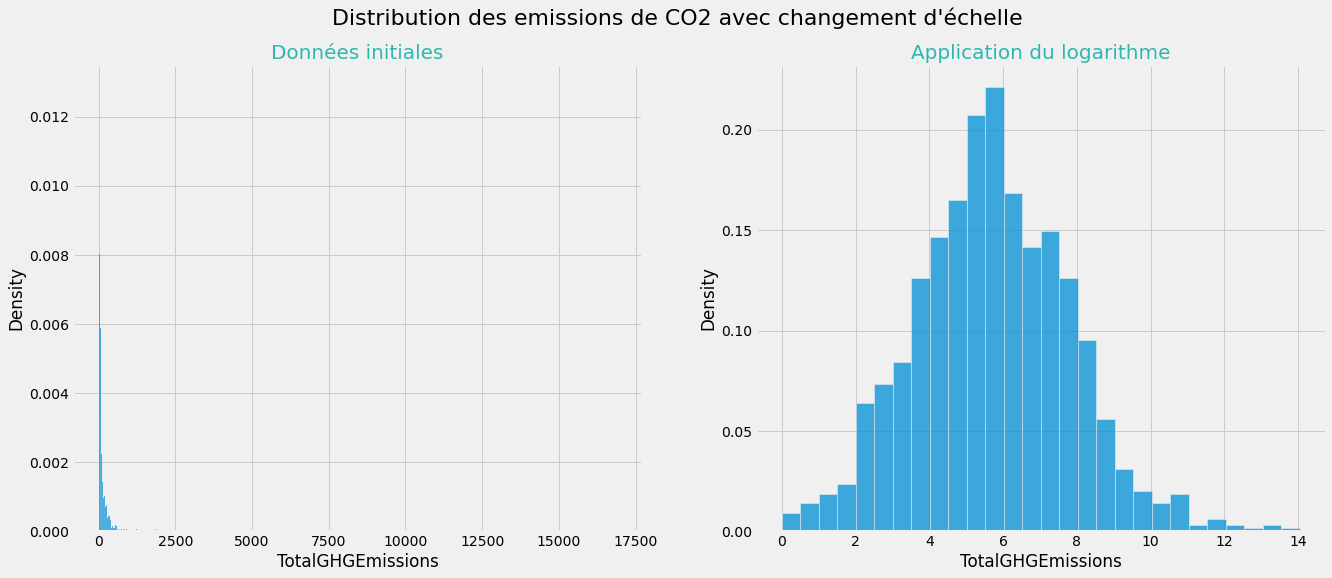

In [294]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=y_train, stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0', fontsize=20)
sns.histplot(data=test_co2, stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0', fontsize=20)
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontsize=22)
plt.show()

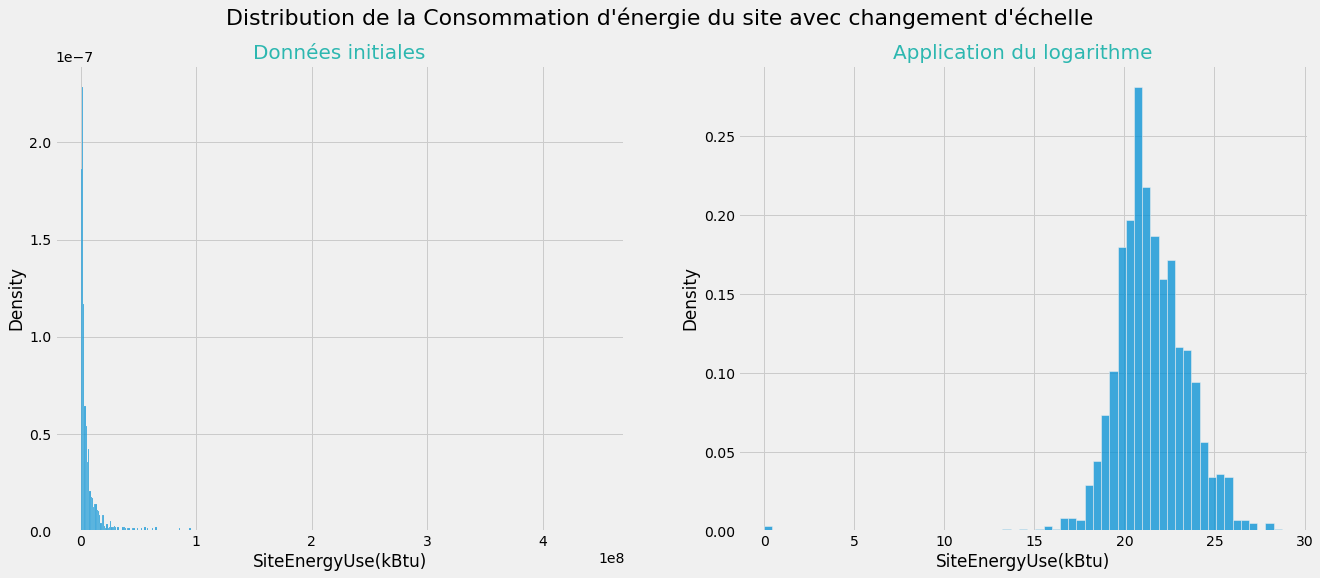

In [295]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=y_train_s, stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0', fontsize=20)
sns.histplot(data=test_site, stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0', fontsize=20)
plt.suptitle("Distribution de la Consommation d'énergie du site avec changement d'échelle", fontsize=22)
plt.show()

In [296]:
Y_train_log= test_co2
Y_train_log_s = test_site

### Normalisation

In [297]:
# copie du x_train et x_test encoder
X_train_log = df_one_var.copy()
X_test_log = df_one_var_test.copy()


X_train_log_s = df_one_var_site.copy()
X_test_log_s = df_one_var_site_test.copy()

In [298]:
#standarlisation cible : emission CO2
std_s = StandardScaler().fit(X_train_log)
X_train_log = std_s.transform(X_train_log)
X_test_log = std_s.transform(X_test_log)

In [299]:
#standarlisation cible : Consommation energie
std_s = StandardScaler().fit(X_train_log_s)
X_train_log_s = std_s.transform(X_train_log_s)
X_test_log_s = std_s.transform(X_test_log_s)

### Target: ``TotalGHGEmissions``

In [301]:
subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

start_time_xboost = timeit.default_timer()
grid_pred_xboost = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)


grid_pred_xboost.fit(X_train_log, Y_train_log)

y_hat_xboost = grid_pred_xboost.predict(X_test_log)

elapsed_time_xboost = timeit.default_timer() - start_time_xboost

In [302]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(grid_pred_xboost.best_params_)

print("Résultats de la validation croisée de la régression svr pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost.cv_results_['mean_test_r2'], 
        grid_pred_xboost.cv_results_['std_test_r2'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
Résultats de la validation croisée de la régression svr pour:
r2 = 0.414 (+/-0.032) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.422 (+/-0.029) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.421 (+/-0.026) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = 0.507 (+/-0.041) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = 0.519 (+/-0.039) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.528 (+/-0.037) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.1}
r2 = 0.465 (+/-0.033) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.471 (+/-0.028) for {'learning_rate': 0.01, 'max_depth': 5, '

In [307]:
#Le coefficient de détermination R2
R2_test_xboost_log = max(grid_pred_xboost.cv_results_['mean_test_r2'])
#La MAE moyenne arithmétique des valeurs absolues des écarts 
MAE_test_xboost_log = min(grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'])
#L'erreur quadratique 
RMSE_test_xboost_log = min(grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'])



### Target ``SiteEnergyUse(kBtu)``

In [304]:
subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

start_time_xboost_s = timeit.default_timer()
grid_pred_xboost_s = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_xboost_s.fit(X_train_log_s, Y_train_log_s)

y_hat_xboost_s = grid_pred_xboost_s.predict(X_test_log_s)

elapsed_xboost_s = timeit.default_timer() - start_time_xboost_s


In [305]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(grid_pred_xboost_s.best_params_)

print("Résultats de la validation croisée de la régression svr pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost_s.cv_results_['mean_test_r2'], 
        grid_pred_xboost_s.cv_results_['std_test_r2'], 
        grid_pred_xboost_s.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )

    

#Le coefficient de détermination R2
R2_test_xboost_log_s = max(grid_pred_xboost_s.cv_results_['mean_test_r2'])
#La MAE moyenne arithmétique des valeurs absolues des écarts 
MAE_test_xboost_log_s = min(grid_pred_xboost_s.cv_results_['mean_test_neg_mean_absolute_error'])
#L'erreur quadratique 
RMSE_test_xboost_log_s = min(grid_pred_xboost_s.cv_results_['mean_test_neg_root_mean_squared_error'])

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
Résultats de la validation croisée de la régression svr pour:
r2 = 0.494 (+/-0.097) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.488 (+/-0.094) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.502 (+/-0.089) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = 0.597 (+/-0.113) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = 0.584 (+/-0.112) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.606 (+/-0.101) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.1}
r2 = 0.535 (+/-0.099) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.533 (+/-0.098) for {'learning_rate': 0.01, 'max_depth': 5, '

In [346]:
resultValidation

,Modèle,Best Param,RMSE,R2,MAE
0,Dummy,{'strategy': 'mean'},667.596050,-0.037098,163.322963
1,Elastic Net,"{'alpha': 10, 'l1_ratio': 0.9, 'tol': 0.01}",541.567145,0.305233,155.531957
2,RdForest,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",502.735904,0.426264,132.676283
3,SVM,"{'C': 10, 'epsilon': 1, 'gamma': 0.01}",662.355673,0.017286,149.237281
4,XGBOOST,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",578.383868,0.255095,138.430928


In [348]:



RMSE_test_xboost= resultValidation.iat[4,2]
R2_test_xboost=resultValidation.iat[4,3]
MAE_test_xboost=   resultValidation.iat[4,4]

RMSE_test_xboost_s= resultValidation_s.iat[4,2]
R2_test_xboost_s=resultValidation_s.iat[4,3]
MAE_test_xboost_s=   resultValidation_s.iat[4,4]

In [337]:
RMSE_test_xboost= [min(xgb_grid.cv_results_['mean_test_neg_root_mean_squared_error'])],
R2_test_xboost=[max(xgb_grid.cv_results_['mean_test_r2'])],
MAE_test_xboost=   [min(xgb_grid.cv_results_['mean_test_neg_mean_absolute_error'])]
RMSE_test_xboost_s= [min(xgb_grid_s.cv_results_['mean_test_neg_root_mean_squared_error'])],
R2_test_xboost_s=[max(xgb_grid_s.cv_results_['mean_test_r2'])],
MAE_test_xboost_s=   [min(xgb_grid_s.cv_results_['mean_test_neg_mean_absolute_error'])]

In [344]:
RMSE_test_xboost.count

<function tuple.count(value, /)>

In [349]:
print('La performance du modèle Regression xboost sur la base de testing')
print('-----------------------------------------------------------------')
print('\n')

print("_______ TotalGHGEmissions _______")
print("RMSE R_xboost    = {:.2f}      vs   RMSE R_xboost  avec log = {:.2f}".format(RMSE_test_xboost, RMSE_test_xboost_log ))
print("R2 R_xboost      = {:.2f}       vs    R2 R_xboost avec log = {:.2f}".format(R2_test_xboost, R2_test_xboost_log ))
print("MAE R_xboost     = {:.2f}     vs     MAE R_xboost avec log = {:.2f}".format(MAE_test_xboost, MAE_test_xboost_log ))
print('\n')

print("_______ SiteEnergyUse(kBtu) _______")
print("RMSE R_xboost    = {:.2f}      vs   RMSE R_xboost  avec log = {:.2f}".format(RMSE_test_xboost_s, RMSE_test_xboost_log_s ))
print("R2 R_xboost      = {:.2f}       vs     R2 R_xboost avec log = {:.2f}".format(R2_test_xboost_s, R2_test_xboost_log_s ))
print("MAE R_xboost     = {:.2f}     vs     MAE R_xboost avec log = {:.2f}".format(MAE_test_xboost_s, MAE_test_xboost_log_s ))



La performance du modèle Regression xboost sur la base de testing
-----------------------------------------------------------------


_______ TotalGHGEmissions _______
RMSE R_xboost    = 578.38      vs   RMSE R_xboost  avec log = 1.33
R2 R_xboost      = 0.26       vs    R2 R_xboost avec log = 0.60
MAE R_xboost     = 138.43     vs     MAE R_xboost avec log = 1.05


_______ SiteEnergyUse(kBtu) _______
RMSE R_xboost    = 13902528.15      vs   RMSE R_xboost  avec log = 1.18
R2 R_xboost      = 0.57       vs     R2 R_xboost avec log = 0.67
MAE R_xboost     = 3766516.98     vs     MAE R_xboost avec log = 0.67


In [350]:

Data_compare_CO2_log = pd.DataFrame({'Metrique':['RMSE', 'R2', 'MAE'],
                              'Sans log':[RMSE_test_xboost, R2_test_xboost,MAE_test_xboost],
                              'Avec log':[RMSE_test_xboost_log,R2_test_xboost_log, MAE_test_xboost_log]})

Data_compare_CO2_log

,Metrique,Sans log,Avec log
0,RMSE,578.383868,1.329421
1,R2,0.255095,0.595728
2,MAE,138.430928,1.050317


Text(0.5, 1.0, 'Avec log : Log-TotalGHGEmissions')

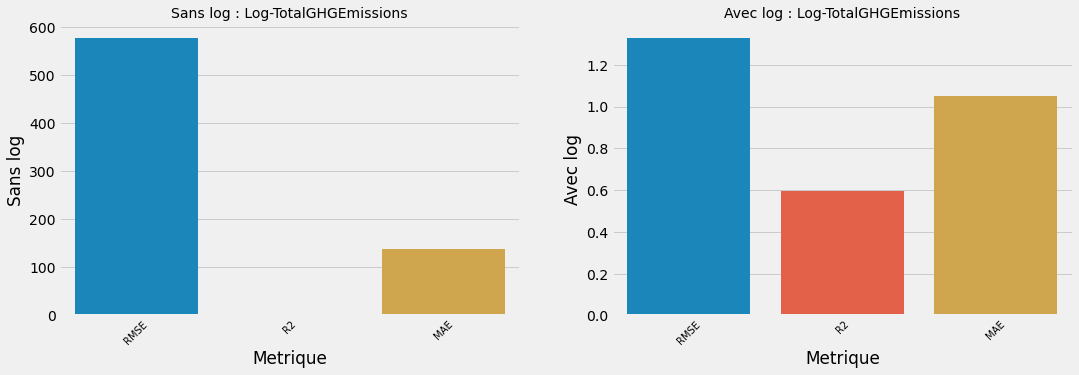

In [351]:
fig = plt.figure(1, figsize=(25, 5))

plt.subplot(131)
#Data_compare_energy = Data_compare_energy.sort_values(by=['Sans ENERGY STAR'])
sns.barplot(x = Data_compare_CO2_log['Metrique'],y = Data_compare_CO2_log["Sans log"])
plt.xticks(rotation=45,fontsize=10)
#plt.ylabel(" ",fontsize=14)
plt.title("Sans log : Log-TotalGHGEmissions", fontsize=14)

plt.subplot(132)
sns.barplot(x = Data_compare_CO2_log['Metrique'],y = Data_compare_CO2_log["Avec log"])
plt.xticks(rotation=45,fontsize=10)
#plt.ylabel(" ",fontsize=14)
plt.title("Avec log : Log-TotalGHGEmissions", fontsize=14)



In [353]:
Data_compare_site_log = pd.DataFrame({'Metrique':['RMSE', 'R2', 'MAE'],
                              'Sans log':[RMSE_test_xboost_s,R2_test_xboost_s,MAE_test_xboost_s],
                              'Avec log':[RMSE_test_xboost_log_s,R2_test_xboost_log_s, MAE_test_xboost_log_s]})

Data_compare_site_log

,Metrique,Sans log,Avec log
0,RMSE,1.390253e+07,1.181014
1,R2,5.718538e-01,0.673413
2,MAE,3.766517e+06,0.667571


Text(0.5, 1.0, 'Avec log : Log-SiteEnergyUse(kBtu)')

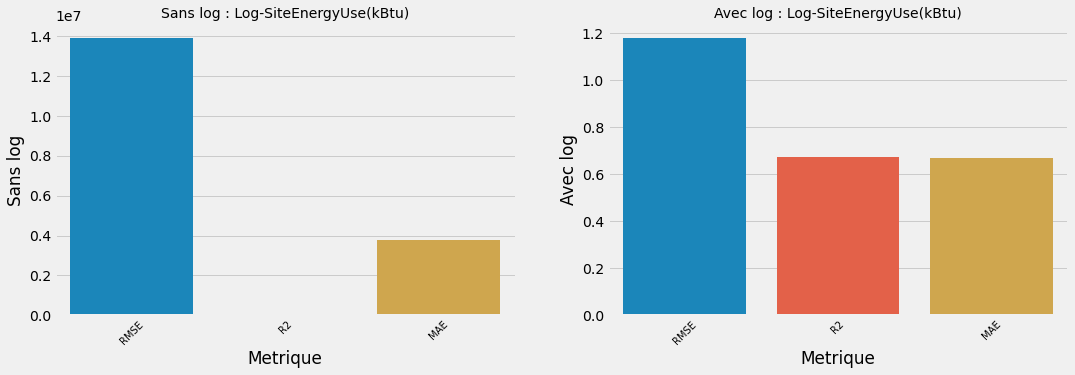

In [354]:
fig = plt.figure(1, figsize=(25, 5))

plt.subplot(131)
#Data_compare_energy = Data_compare_energy.sort_values(by=['Sans ENERGY STAR'])
sns.barplot(x = Data_compare_site_log['Metrique'],y = Data_compare_site_log["Sans log"])
plt.xticks(rotation=45,fontsize=10)
#plt.ylabel(" ",fontsize=14)
plt.title("Sans log : Log-SiteEnergyUse(kBtu)", fontsize=14)

plt.subplot(132)
sns.barplot(x = Data_compare_site_log['Metrique'],y = Data_compare_site_log["Avec log"])
plt.xticks(rotation=45,fontsize=10)
#plt.ylabel(" ",fontsize=14)
plt.title("Avec log : Log-SiteEnergyUse(kBtu)", fontsize=14)



## Pertinences d'ENERGYSTARScore <a class="anchor" id="partie5"></a>


L’ENERGY STAR Score est un outil de dépistage aidant à évaluer les performances d’émission de GES d’une propriété
par rapport à des bâtiments similaires.
- Cet indicateur se base sur une échelle de 0 à 100 dont la médiane est 50.
- Si le score est >= 75, le bâtiment peut être admissible à la certification ENERGY STAR.

A partir du meilleur résultat après optimisation, nous allons reconstruire un modèle avec les meilleurs paramètres obtenus, mais en enlevant de la dataframe la varaible ENERGYSTARScore

Ensuite nous allons analyser quelles sont les variables les plus importantes pour ce modèle.

Afin de comparer le fonctionnement de modèles différents, nous allons travailler avec le RandomForestRegressor et le GradientBoostingRegressor.


In [356]:
#data_sans_energy =  data_feature_globale.copy()
X_train_sans_energy =  df_one_var.copy()

In [357]:
X_train_sans_energy = X_train_sans_energy.drop('ENERGYSTARScore', axis = 1)
X_train_sans_energy.head(3)

,Campus,NonResidential,Nonresidential COS,Nonresidential WA,SPS-District K-12,Distribution Center\n,Education,Health,Hospital,Hotel/Senior Care/Housing,...,NORTH,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,BuildingAge
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,46340.0,98134,14
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,41,589921.0,98104,29
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,5,138106.0,98106,24


In [358]:
X_test_sans_energy =  df_one_var_test.copy()
X_test_sans_energy = X_test_sans_energy.drop('ENERGYSTARScore', axis = 1)
X_test_sans_energy.head(3)

,Campus,NonResidential,Nonresidential COS,Nonresidential WA,SPS-District K-12,Distribution Center\n,Education,Health,Hospital,Hotel/Senior Care/Housing,...,NORTH,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST,NumberofBuildings,NumberofFloors,PropertyGFATotal,ZipCode,BuildingAge
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,4,40000.0,98104,101
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,76,1952220.0,98104,30
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,4,129000.0,98134,115


In [359]:
#Starditsation , TARGET : TotalGHGEmissions
std = StandardScaler().fit(X_train_sans_energy)
X_train = std.transform(X_train_sans_energy)
X_test = std.transform(X_test_sans_energy)


In [360]:
#TARGET: SiteEnergyUse(kBtu)
#Suppression de energystarscore sur la cible site energy(x_train et x_test)
X_train_sans_energy_s =  df_one_var_site.copy()
X_train_sans_energy_s = X_train_sans_energy_s.drop('ENERGYSTARScore', axis = 1)

X_test_sans_energy_s =  df_one_var_site_test.copy()
X_test_sans_energy_s = X_test_sans_energy_s.drop('ENERGYSTARScore', axis = 1)


### Prédiction en utilisant le Gradient Boosting et le Random Forest

### Cible ``TotalGHGEmission``

In [361]:
subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

start_time_xboost = timeit.default_timer()
grid_pred_xboost = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)


grid_pred_xboost.fit(X_train, y_train)

y_hat_xboost = grid_pred_xboost.predict(X_test)

elapsed_time_xboost = timeit.default_timer() - start_time_xboost


In [368]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(grid_pred_xboost.best_params_)

print("Résultats de la validation croisée de la régression svr pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost.cv_results_['mean_test_r2'], 
        grid_pred_xboost.cv_results_['std_test_r2'], 
        grid_pred_xboost.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )

    

#Le coefficient de détermination R2
R2_test_xboost_sans_energy = max(grid_pred_xboost.cv_results_['mean_test_r2'])
#La MAE moyenne arithmétique des valeurs absolues des écarts 
MAE_test_xboost_sans_energy = min(grid_pred_xboost.cv_results_['mean_test_neg_mean_absolute_error'])
#L'erreur quadratique 
RMSE_test_xboost_sans_energy = min(grid_pred_xboost.cv_results_['mean_test_neg_root_mean_squared_error'])

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}
Résultats de la validation croisée de la régression svr pour:
r2 = -0.637 (+/-1.436) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.127 (+/-0.533) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.304 (+/-0.204) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = -1.926 (+/-3.891) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = -0.291 (+/-1.276) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.226 (+/-0.402) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.1}
r2 = -0.721 (+/-1.617) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.263 (+/-0.324) for {'learning_rate': 0.01, 'max_depth':

### Target ``SiteEnergyUse(kBtu)``

In [364]:
subsample = [0.9,0.5,0.1]
n_estimators = [100,200]
max_depth = [3,5,8,10]
learning_range = np.arange(0.01,0.11,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

start_time_xboost_s = timeit.default_timer()
grid_pred_xboost_s = model_selection.GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_pred_xboost_s.fit(X_train_s, y_train_s)

y_hat_xboost_s = grid_pred_xboost_s.predict(X_test_s)

elapsed_xboost_sans_energy_s = timeit.default_timer() - start_time_xboost_s

In [365]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(grid_pred_xboost_s.best_params_)

print("Résultats de la validation croisée de la régression svr pour:")
for mean_r2, std_r2, params in zip(
        grid_pred_xboost_s.cv_results_['mean_test_r2'], 
        grid_pred_xboost_s.cv_results_['std_test_r2'], 
        grid_pred_xboost_s.cv_results_['params']           
    ):

    print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
        mean_r2,
        std_r2,
        params
    ) )

    

#Le coefficient de détermination R2
R2_test_xboost_sans_energy_s = max(grid_pred_xboost_s.cv_results_['mean_test_r2'])
#La MAE moyenne arithmétique des valeurs absolues des écarts 
MAE_test_xboost_sans_energy_s = min(grid_pred_xboost_s.cv_results_['mean_test_neg_mean_absolute_error'])
#L'erreur quadratique 
RMSE_test_xboost_sans_energy_s = min(grid_pred_xboost_s.cv_results_['mean_test_neg_root_mean_squared_error'])

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.5}
Résultats de la validation croisée de la régression svr pour:
r2 = 0.515 (+/-0.129) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.570 (+/-0.144) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
r2 = 0.435 (+/-0.130) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.1}
r2 = 0.611 (+/-0.129) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
r2 = 0.651 (+/-0.145) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
r2 = 0.563 (+/-0.125) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.1}
r2 = 0.554 (+/-0.130) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
r2 = 0.598 (+/-0.139) for {'learning_rate': 0.01, 'max_depth': 5, '

In [366]:

print('La performance du modèle Regression  sur la base de testing')
print('-----------------------------------------------------------------')
print('\n')

print("_______ TotalGHGEmissions _______")
#print("Temps avec ENERGY STAR  = {:.2f}s          vs   Temps sans  ENERGY STAR : {:.2f}s".format(elapsed_xboost, elapsed_xboost_sans_energy))
print("RMSE R_xboost avec ENERGY STAR  = {:.2f}   vs    sans  ENERGY STAR RMSE = {:.2f}".format(RMSE_test_xboost, RMSE_test_xboost_sans_energy ))
print("R2 R_xboost avec ENERGY STAR   = {:.2f}      vs    sans  ENERGY STAR   R2 = {:.2f}".format(R2_test_xboost, R2_test_xboost_sans_energy ))
print("MAE R_xboost avec ENERGY STAR   = {:.2f}    vs   sans  ENERGY STAR  MAE = {:.2f}".format(MAE_test_xboost, MAE_test_xboost_sans_energy ))
print('\n')

print("_______ SiteEnergyUse(kBtu) _______")
#print("Temps ecoulé  = {:.2f}s         vs   Temps sans  ENERGY STAR : {:.2f}s".format(elapsed_xboost_log_s, elapsed_xboost_sans_energy_s))
print("RMSE R_xboost    = {:.2f}   vs     sans  ENERGY STAR RMSE = {:.2f}".format(RMSE_test_xboost_s, RMSE_test_xboost_sans_energy_s ))
print("R2 R_xboost      = {:.2f}         vs    sans  ENERGY STAR  R2 = {:.2f}".format(R2_test_xboost_s, R2_test_xboost_sans_energy_s ))
print("MAE R_xboost     = {:.2f}   vs    sans  ENERGY STAR MAE = {:.2f}".format(MAE_test_xboost_log_s, MAE_test_xboost_sans_energy_s ))



La performance du modèle Regression  sur la base de testing
-----------------------------------------------------------------


_______ TotalGHGEmissions _______
RMSE R_xboost avec ENERGY STAR  = 578.38   vs    sans  ENERGY STAR RMSE = 529.76
R2 R_xboost avec ENERGY STAR   = 0.26      vs    sans  ENERGY STAR   R2 = 0.37
MAE R_xboost avec ENERGY STAR   = 138.43    vs   sans  ENERGY STAR  MAE = 144.82


_______ SiteEnergyUse(kBtu) _______
RMSE R_xboost    = 13902528.15   vs     sans  ENERGY STAR RMSE = 12079999.81
R2 R_xboost      = 0.57         vs    sans  ENERGY STAR  R2 = 0.70
MAE R_xboost     = 0.67   vs    sans  ENERGY STAR MAE = 3625021.50


In [369]:
Data_compare_CO2 = pd.DataFrame({'Metrique':['RMSE', 'R2', 'MAE'],
                              'Sans ENERGY STAR':[RMSE_test_xboost_sans_energy,R2_test_xboost_sans_energy,MAE_test_xboost_sans_energy],
                              'Avec ENERGY STAR':[RMSE_test_xboost,R2_test_xboost, MAE_test_xboost]})




In [370]:
Data_compare_CO2

,Metrique,Sans ENERGY STAR,Avec ENERGY STAR
0,RMSE,529.755207,578.383868
1,R2,0.366626,0.255095
2,MAE,144.824634,138.430928


In [372]:
Data_compare_energy = pd.DataFrame({'Metrique':['RMSE', 'R2', 'MAE'],
                              'Sans ENERGY STAR':[RMSE_test_xboost_sans_energy_s,R2_test_xboost_sans_energy_s,MAE_test_xboost_sans_energy_s],
                              'Avec ENERGY STAR':[RMSE_test_xboost_s,R2_test_xboost_s, MAE_test_xboost_s]})




In [373]:
Data_compare_energy

,Metrique,Sans ENERGY STAR,Avec ENERGY STAR
0,RMSE,1.208000e+07,1.390253e+07
1,R2,6.955765e-01,5.718538e-01
2,MAE,3.625021e+06,3.766517e+06


Text(0.5, 1.0, 'Avec ENERGY STAR : SiteEnergyUse(kBtu)')

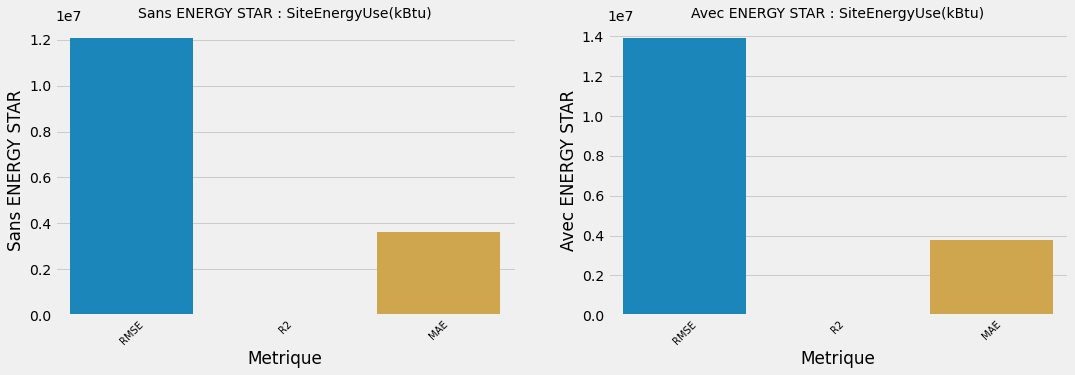

In [374]:
fig = plt.figure(1, figsize=(25, 5))

plt.subplot(131)
#Data_compare_energy = Data_compare_energy.sort_values(by=['Sans ENERGY STAR'])
sns.barplot(x = Data_compare_energy['Metrique'],y = Data_compare_energy["Sans ENERGY STAR"])
plt.xticks(rotation=45,fontsize=10)
#plt.ylabel(" ",fontsize=14)
plt.title("Sans ENERGY STAR : SiteEnergyUse(kBtu)", fontsize=14)

plt.subplot(132)
sns.barplot(x = Data_compare_energy['Metrique'],y = Data_compare_energy["Avec ENERGY STAR"])
plt.xticks(rotation=45,fontsize=10)
#plt.ylabel(" ",fontsize=14)
plt.title("Avec ENERGY STAR : SiteEnergyUse(kBtu)", fontsize=14)

Text(0.5, 1.0, 'Avec ENERGY STAR : TotalGHGEmissions')

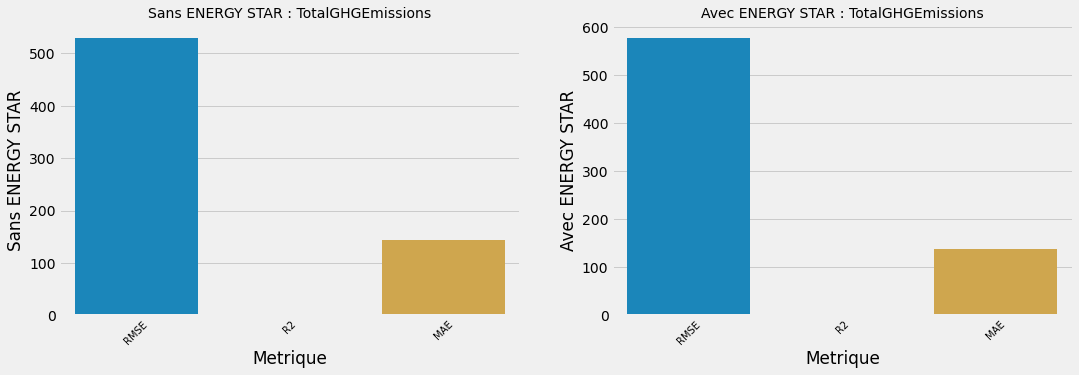

In [375]:
fig = plt.figure(1, figsize=(25, 5))

plt.subplot(131)
#Data_compare_energy = Data_compare_energy.sort_values(by=['Sans ENERGY STAR'])
sns.barplot(x = Data_compare_CO2['Metrique'],y = Data_compare_CO2["Sans ENERGY STAR"])
plt.xticks(rotation=45,fontsize=10)
#plt.ylabel(" ",fontsize=14)
plt.title("Sans ENERGY STAR : TotalGHGEmissions", fontsize=14)

plt.subplot(132)
sns.barplot(x = Data_compare_CO2['Metrique'],y = Data_compare_CO2["Avec ENERGY STAR"])
plt.xticks(rotation=45,fontsize=10)
#plt.ylabel(" ",fontsize=14)
plt.title("Avec ENERGY STAR : TotalGHGEmissions", fontsize=14)